In [1]:
import scipy.linalg as la
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
from helper_functions.grape_functions import *
from main_grape.Grape_original import Grape
from helper_functions.qutip_open_verification import *
import h5py

%pylab inline
import matplotlib as mpl
mpl.rc("savefig", dpi=200)

print parentdir
from IPython import display


Populating the interactive namespace from numpy and matplotlib
/home/nelson/Simulations/Mohamed/OQOC_Github


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import qutip as qt

def mmt_open_qutip_verification(datafile, idx,pulse = []):
    
    
    # load data from file
    with h5py.File(datafile,'r') as hf:
    
        gate_time = np.array(hf.get('total_time'))
        gate_steps = np.array(hf.get('steps'))
        H0 = np.array(hf.get('H0'))
        error = np.array(hf.get('error'))
        Hops = np.array(hf.get('Hops'))
        initial_vectors_c = np.array(hf.get('initial_vectors_c'))
        target_vectors_c = np.array(hf.get('target_vectors_c'))
        c_ops = np.array(hf.get('c_ops'))
        if pulse == []:
            uks = np.array(hf.get('uks'))[idx]
        else:
            uks = pulse
            
        e_op = np.array(hf.get('expect_op'))
        f_op = np.array(hf.get('forbid_op'))

        
    
    max_abs_diff_list = []
    all_close_list = []
    
    # H0 and Hops
    H0_qobj = qt.Qobj(H0)
    Hops_qobj = []
    
    e_op = qt.Qobj(e_op)
    f_op = qt.Qobj(f_op)
    for Hop in Hops:
        Hops_qobj.append(qt.Qobj(Hop))
            
            
    cops_qobj = []

    for cop in c_ops:
        cops_qobj.append(qt.Qobj(cop))
    # define time    
    tlist = np.linspace(0,gate_time,gate_steps+1)
    dt = float(gate_time)/gate_steps
    
        
    # append zero control pulse at the end of uks (final timestep)
    
    uks_t0 = np.zeros((uks.shape[0],1))
    uks = np.hstack([uks,uks_t0])
    
        
    r = []
    f = []
    # looping over each initial vector
    for init_vector_id in range(len(initial_vectors_c)):
        
        
        # initial vector
        psi0 = qt.Qobj(initial_vectors_c[init_vector_id])
        target = qt.Qobj(target_vectors_c[init_vector_id])
        # make functions to return uks field
        def make_get_uks_func(id):
            def _function(t,args=None):
                time_id = int(t/dt)
                if time_id >= len (uks[0]):
                    time_id = len (uks[0]) -1
                return uks[id][time_id]
            return _function
        
        # create the time-dependent Hamiltonian list
        Ht_list = []
        Ht_list.append(H0_qobj)
        for ii in range(len(Hops)):
            Ht_list.append([Hops_qobj[ii],make_get_uks_func(ii)])
            #us = np.asarray(np.reshape(uks[ii],[len(uks[ii])]))
            
            #Ht_list.append([Hops_qobj[ii],us])
        
        opts = qt.Odeoptions(method='adams', nsteps=100000, atol=1e-10, rtol=1e-10)
        
        #args = {}
#output = mesolve(hamiltonian_JC, psi0, time_list, jump_op_list, [sm.dag()*sm, a.dag()*a, a, sm], args=args, options=me_options)
        
        # solving the Schrodinger evolution in QuTiP's sesolve
        #output = qt.sesolve(Ht_list, psi0, tlist, [])
        
        output = qt.mesolve(Ht_list, psi0, tlist, cops_qobj,[e_op,f_op])
        r.append(np.sum(output.expect[0]))
        f.append(output.expect[1][-1])
    return r,f
        
       

(1, 300)
(300,)


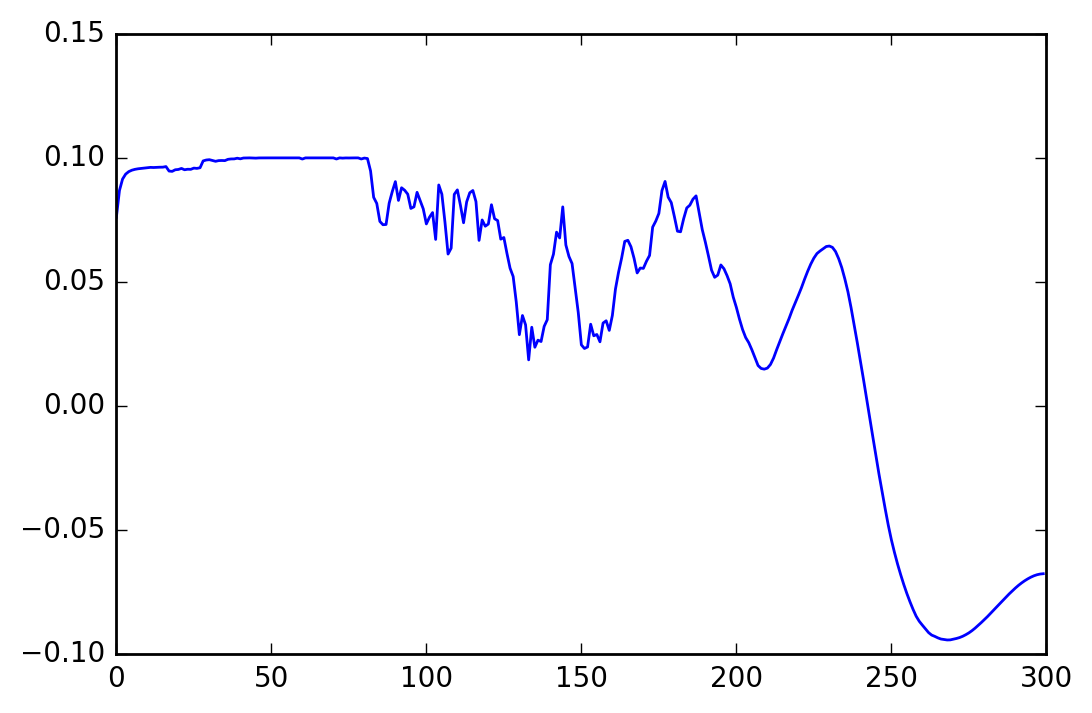

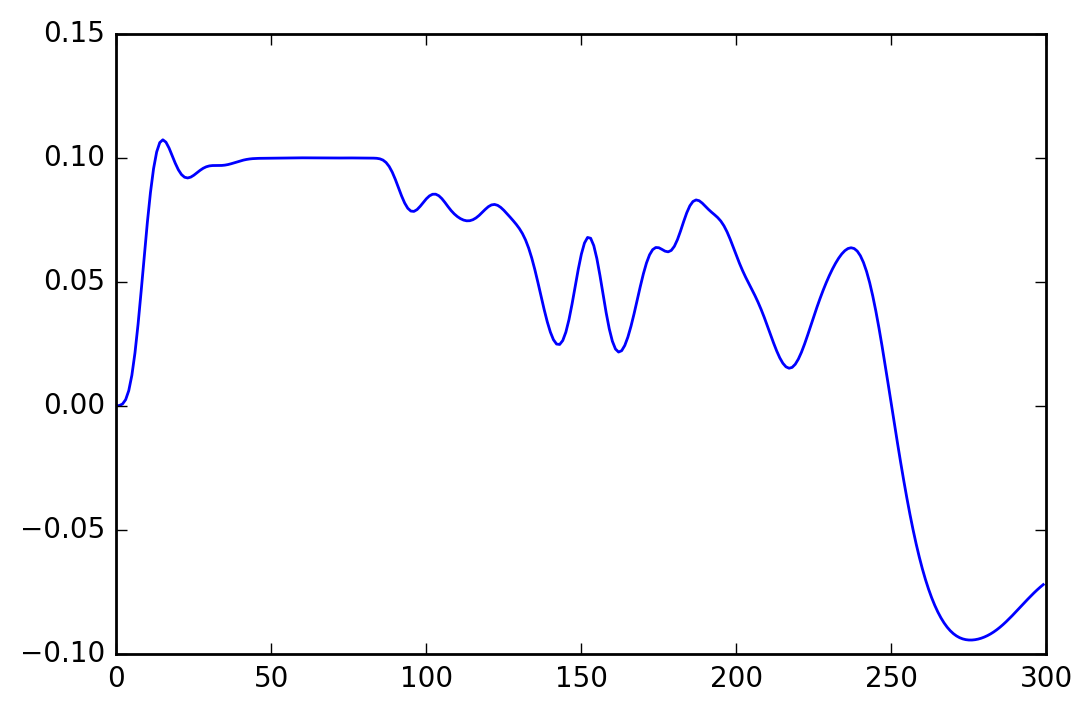

In [3]:
datafile = "/home/nelson/Simulations/Mohamed/00069_JC.h5" #30 is the best 44 is with reg  61,62,65,69 better with re
with h5py.File(datafile,'r') as hf:
    
    uks = list(hf.get('uks'))[-1]
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 30.0       # sample rate, Hz
cutoff = 2  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)
plot(uks[0])
print np.shape(uks)
# Plot the frequency response.
u = butter_lowpass_filter(uks[0],cutoff,fs)
figure()
plot(u)
print np.shape(u)

In [104]:
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 30.0       # sample rate, Hz
cutoff = 3

(1, 300)
([-131.82953560393835, 107.81805974048197], [0.095121720271455726, 0.094958550964126212])
44
([-136.33927370624377, 112.05191918142653], [0.083595213285728998, 0.085557932691097863])


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:20: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


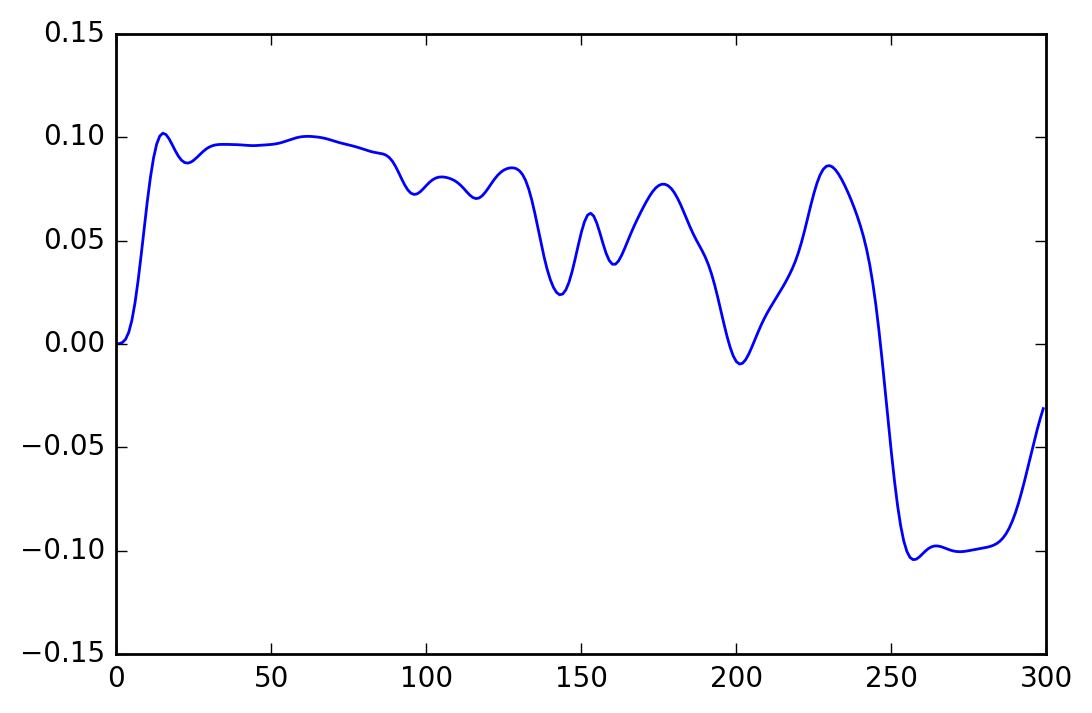

In [5]:
num = 
datafile = "/home/nelson/Simulations/Mohamed/000"+str(num)+"_JC.h5" #30 is the best 44 is with reg  61,62,65,69,72 better with regs
with h5py.File(datafile,'r') as hf:
    
    uks = list(hf.get('uks'))
    f = butter_lowpass_filter(np.array(hf.get('uks'))[-1],cutoff,fs)
print np.shape(f)
a = mmt_open_qutip_verification(datafile,0,f)

print a
#plot( np.arange(len(uks[-1][0])),uks[-1][0])
plot(np.arange(len(uks[-1][0])),f[0])
err1 = []
print len(uks)

show = 1
for ii in range (show):
    
    a = mmt_open_qutip_verification(datafile,len(uks)-show+ii)
    err1.append(a)
    print a
    
#figure(
#plot(np.arange(len(err1)),err1)

In [2]:
import qutip as qt

def open_qutip_verification(datafile):
    
    
    # load data from file
    with h5py.File(datafile,'r') as hf:
    
        gate_time = np.array(hf.get('total_time'))
        gate_steps = np.array(hf.get('steps'))
        H0 = np.array(hf.get('H0'))
        error = np.array(hf.get('error'))
        Hops = np.array(hf.get('Hops'))
        initial_vectors_c = np.array(hf.get('initial_vectors_c'))
        target_vectors_c = np.array(hf.get('target_vectors_c'))
        idx = list(error).index(np.min(error))
        c_ops = np.array(hf.get('c_ops'))
        uks = np.array(hf.get('uks'))[idx]

        
    
    max_abs_diff_list = []
    all_close_list = []
    
    # H0 and Hops
    H0_qobj = qt.Qobj(H0)
    Hops_qobj = []

    for Hop in Hops:
        Hops_qobj.append(qt.Qobj(Hop))
            
            
    cops_qobj = []

    for cop in c_ops:
        cops_qobj.append(qt.Qobj(cop))
    # define time    
    tlist = np.linspace(0,gate_time,gate_steps+1)
    dt = gate_time/gate_steps
    
        
    # append zero control pulse at the end of uks (final timestep)
    uks_t0 = np.zeros((uks.shape[0],1))
    uks = np.hstack([uks,uks_t0])
    
    
    # looping over each initial vector
    for init_vector_id in range(len(initial_vectors_c)):
        
        print "Verifying init vector id: %d" %(init_vector_id)
        
        # initial vector
        psi0 = qt.Qobj(initial_vectors_c[init_vector_id])
        target = qt.Qobj(target_vectors_c[init_vector_id])
        # make functions to return uks field
        def make_get_uks_func(id):
            def _function(t,args=None):
                time_id = int(t/dt)
                return uks[id][time_id]
            return _function
        
        # create the time-dependent Hamiltonian list
        Ht_list = []
        Ht_list.append(H0_qobj)
        for ii in range(len(Hops)):
            Ht_list.append([Hops_qobj[ii],make_get_uks_func(ii)])
            #us = np.asarray(np.reshape(uks[ii],[len(uks[ii])]))
            
            #Ht_list.append([Hops_qobj[ii],us])
        
        opts = qt.Odeoptions(method='adams', nsteps=100000, atol=1e-10, rtol=1e-10)
        
        #args = {}
#output = mesolve(hamiltonian_JC, psi0, time_list, jump_op_list, [sm.dag()*sm, a.dag()*a, a, sm], args=args, options=me_options)
        
        # solving the Schrodinger evolution in QuTiP's sesolve
        #output = qt.sesolve(Ht_list, psi0, tlist, [])
        
        output = qt.mesolve(Ht_list, psi0, tlist, cops_qobj,[psi0*psi0.dag(), target*target.dag()])
        
        print np.max(output.expect[1]),1-error[idx]
        print np.argmax(output.expect[1])
        
        interm_occ = np.ones(len(output.expect[1])) - output.expect[1] - output.expect[0]
        fig, ax = plt.subplots(figsize=(9,6))
        np.save( str(datafile)+"_g", output.expect[0])
        np.save( str(datafile)+"_e", output.expect[1])
        np.save(str(datafile)+"_r", interm_occ)
        np.save( str(datafile)+"_t", tlist)
        ax.plot(tlist, output.expect[0], label='initial')
        ax.plot(tlist, interm_occ, label='intermediate')
        ax.plot(tlist, output.expect[1], label='target')
        ax.legend()
        #ax.set_ylim(-0.01,1.1)
        ax.set_xlabel('Time [ns]')
        ax.set_ylabel('Occupation probability')
        
        

Verifying init vector id: 0
0.98031547137 [ 0.9808448]
400
Verifying init vector id: 0
0.840650444387 [ 0.83547747]
389
Verifying init vector id: 0
0.916474348983 [ 0.09047431]
195


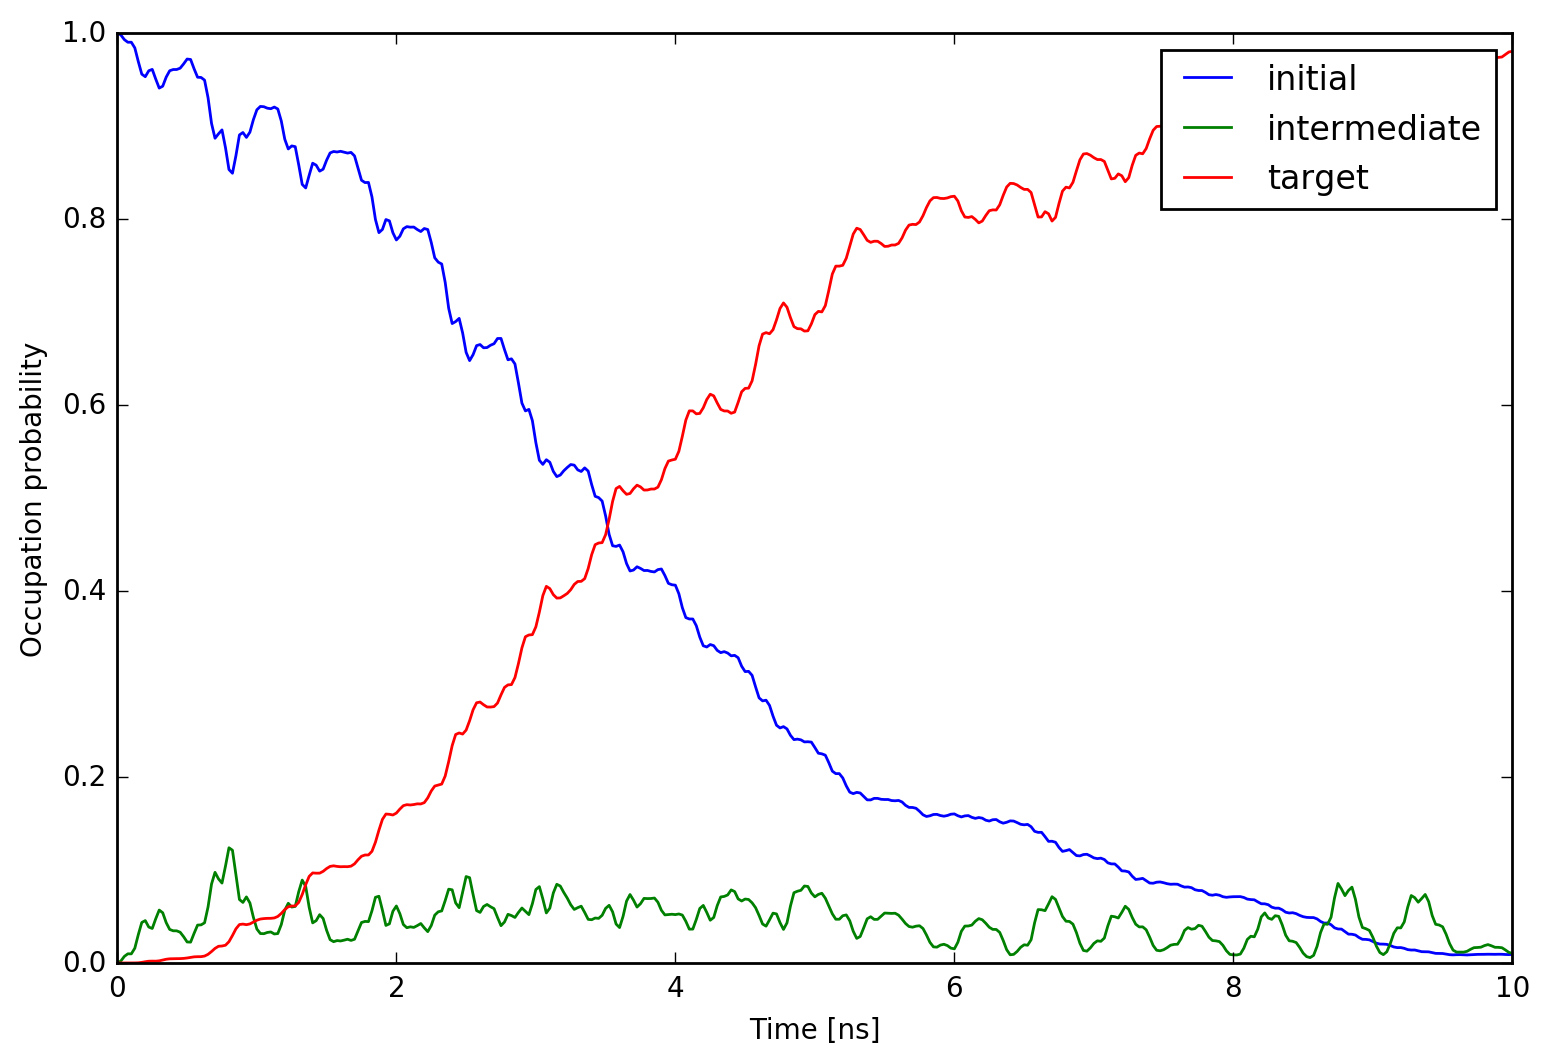

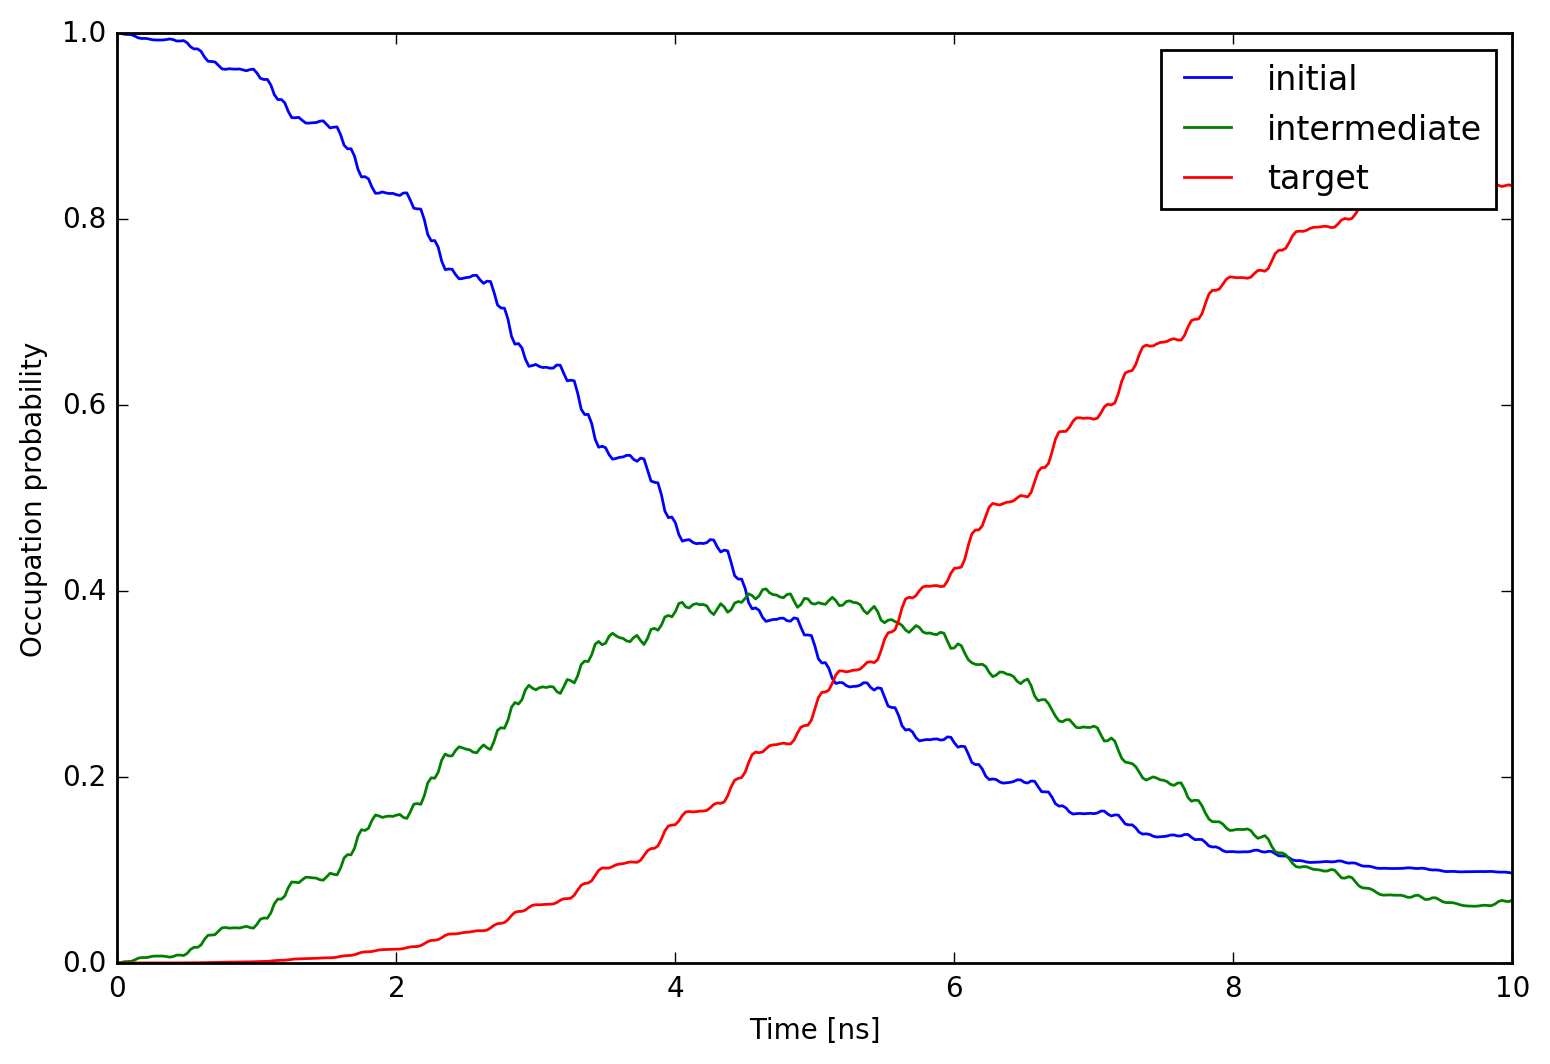

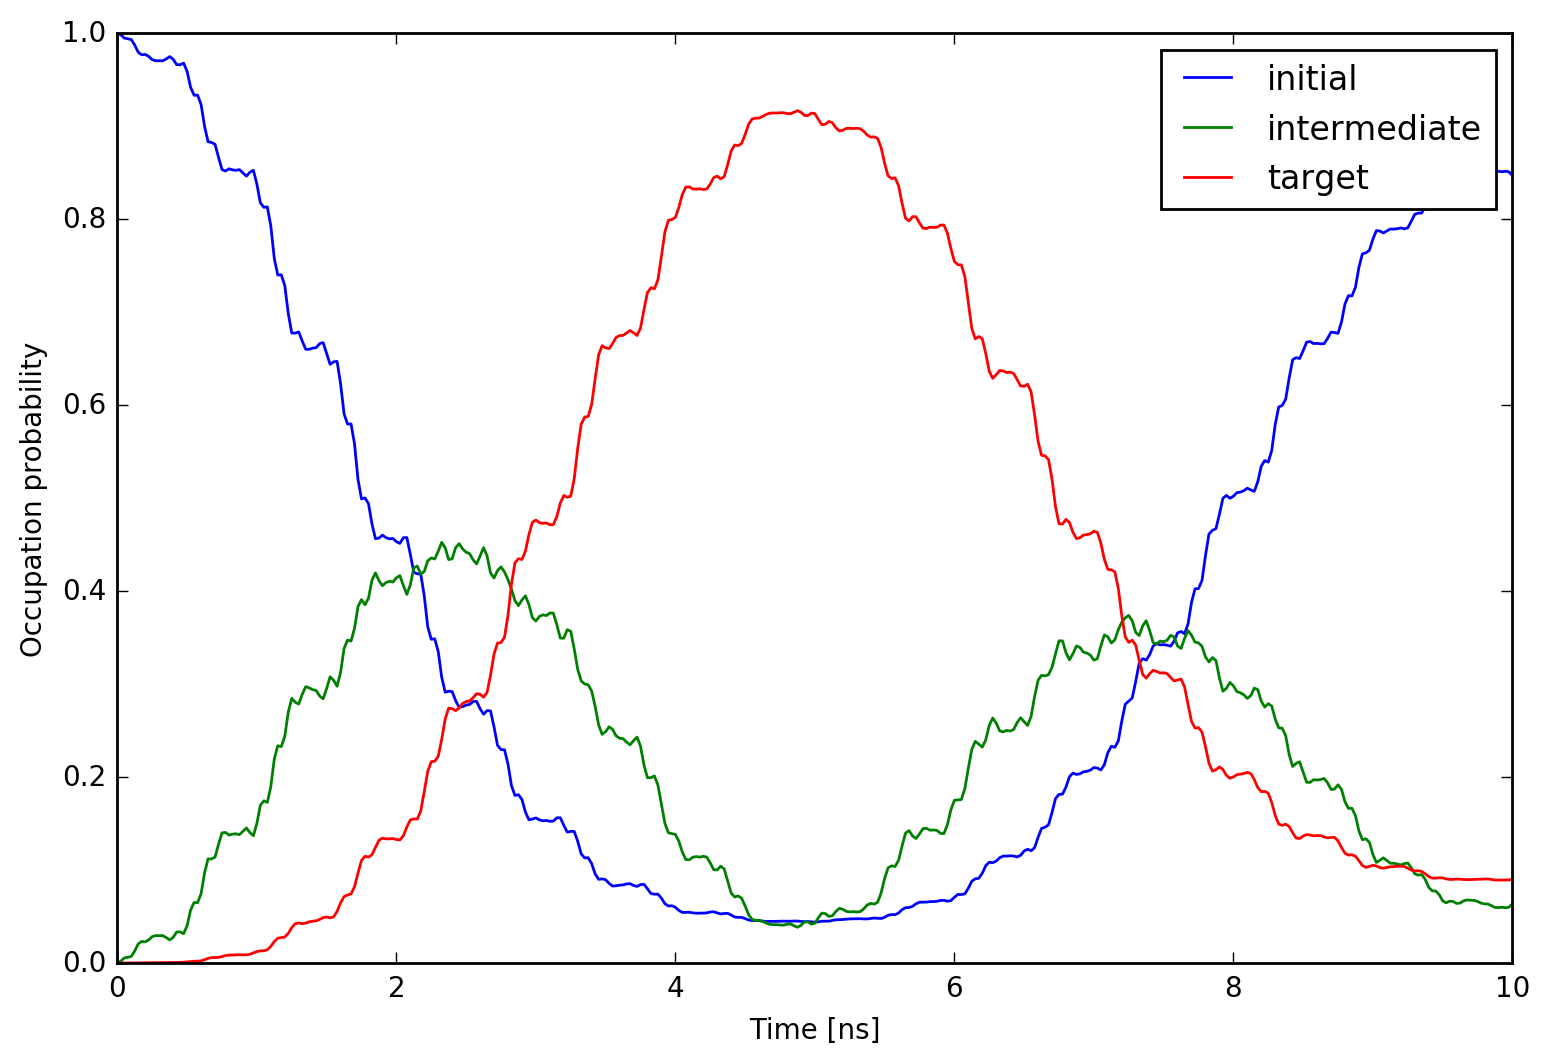

In [35]:
optfile = '/home/mohamed/Data/00099_Lambda.h5' #
datafile = '/home/mohamed/Data/00108_Lambda.h5'
#datafile = '/home/mohamed/Data/00109_Lambda.h5'

with h5py.File(optfile,'r') as hf:
    idx = np.argmin(hf.get('error'))
    uks1 = np.array(hf.get('uks'))[idx]
    
#figure()
#plt.plot(uks1[0])
#print (uks1)
with h5py.File(datafile,'r') as hf:
    idx = np.argmin(hf.get('error'))
    uks1 = np.array(hf.get('uks'))[idx]
#plt.plot(uks1[0])
#plt.show()

open_qutip_verification(optfile)
open_qutip_verification(datafile)

datafile = '/home/mohamed/Data/00109_Lambda.h5'
open_qutip_verification(datafile)



[ 2.9  3.   4.6  4.7  4.8 -4.8 -4.7 -4.6 -3.  -2.9]
47
[ 2.9  3.   4.6  4.8 -4.8 -4.6 -3.  -2.9]
[ 3.2  5.  -5.  -3.2]


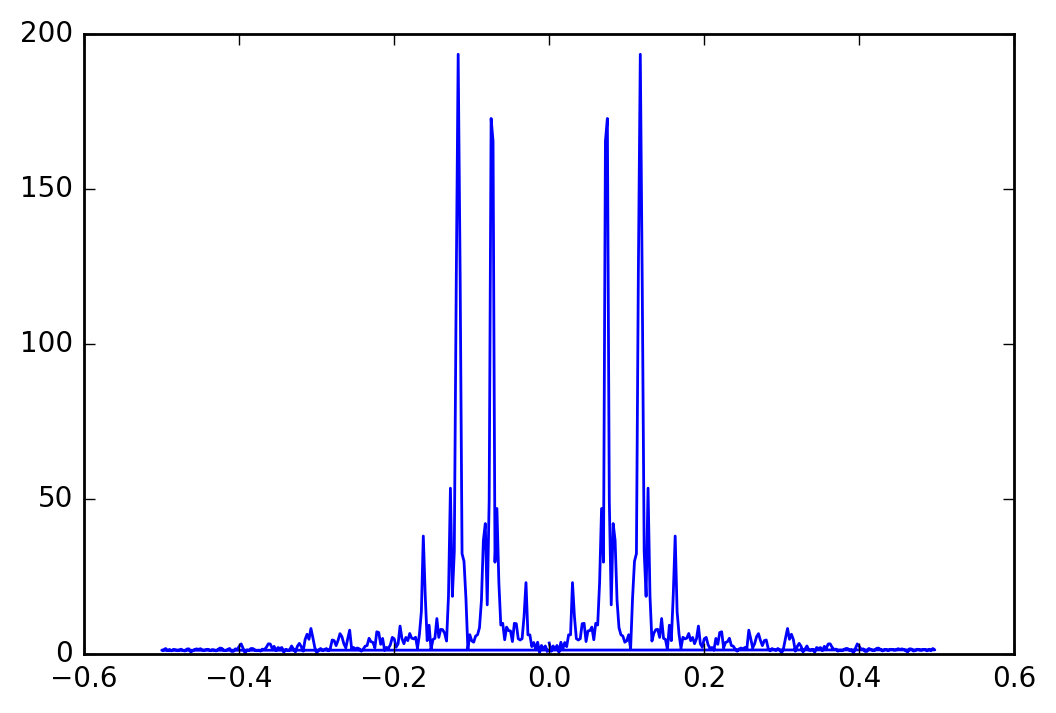

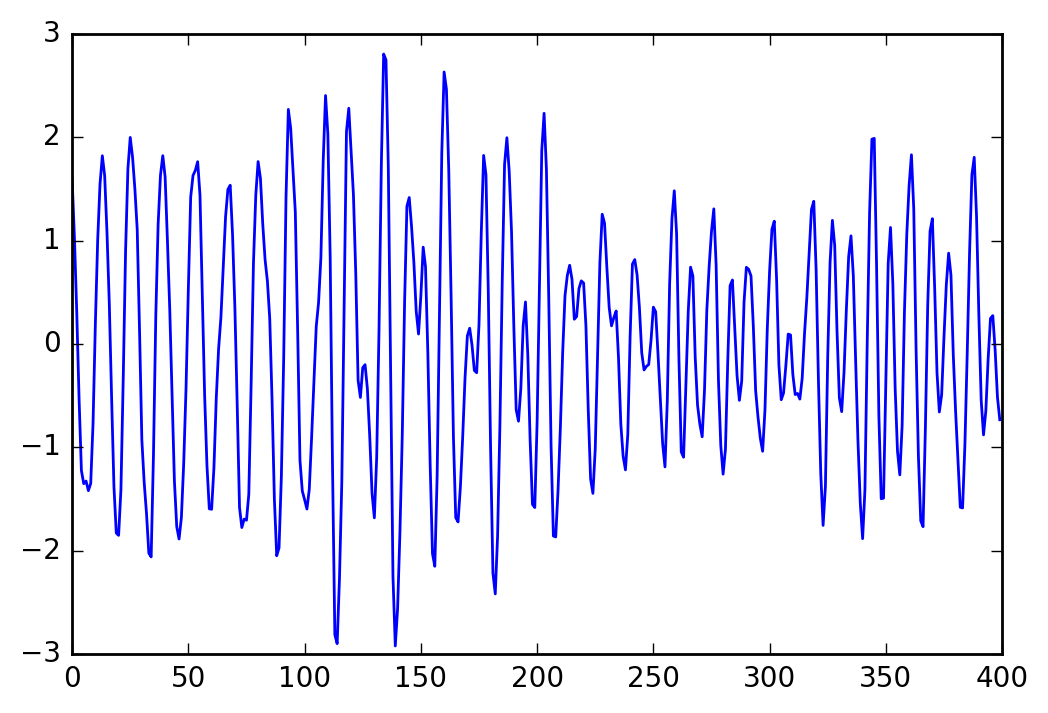

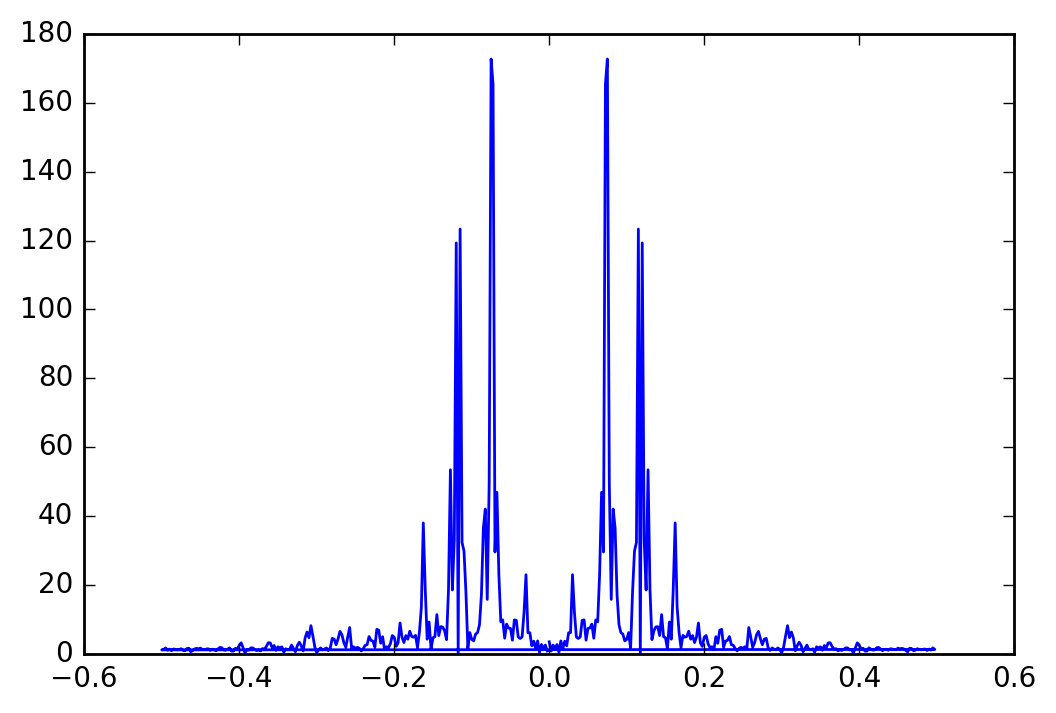

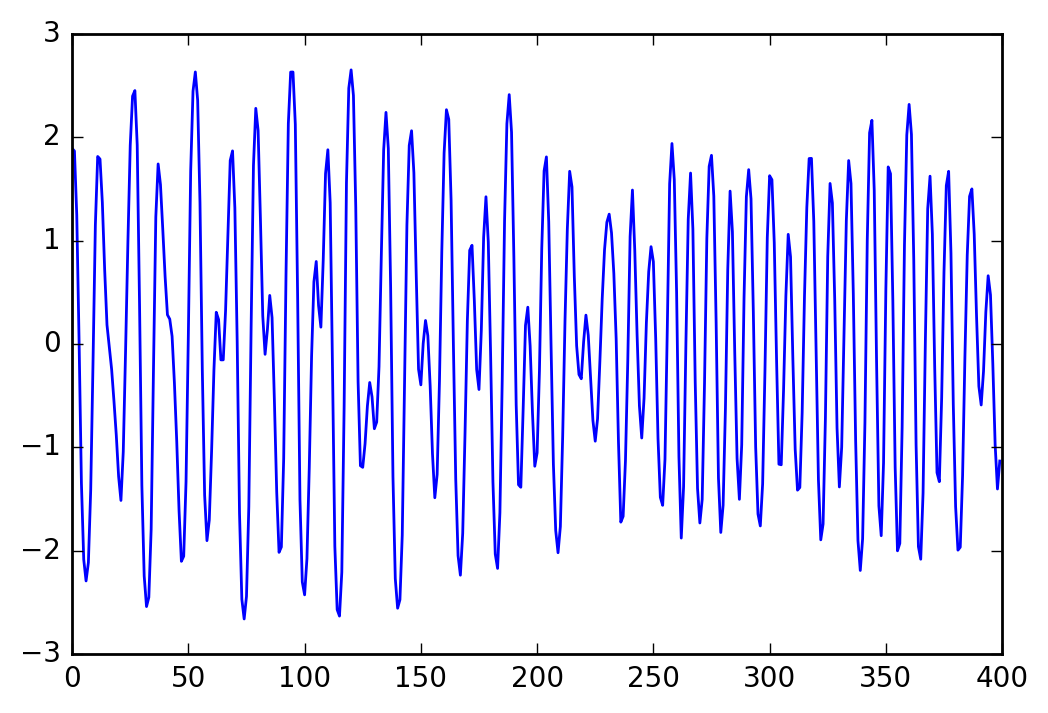

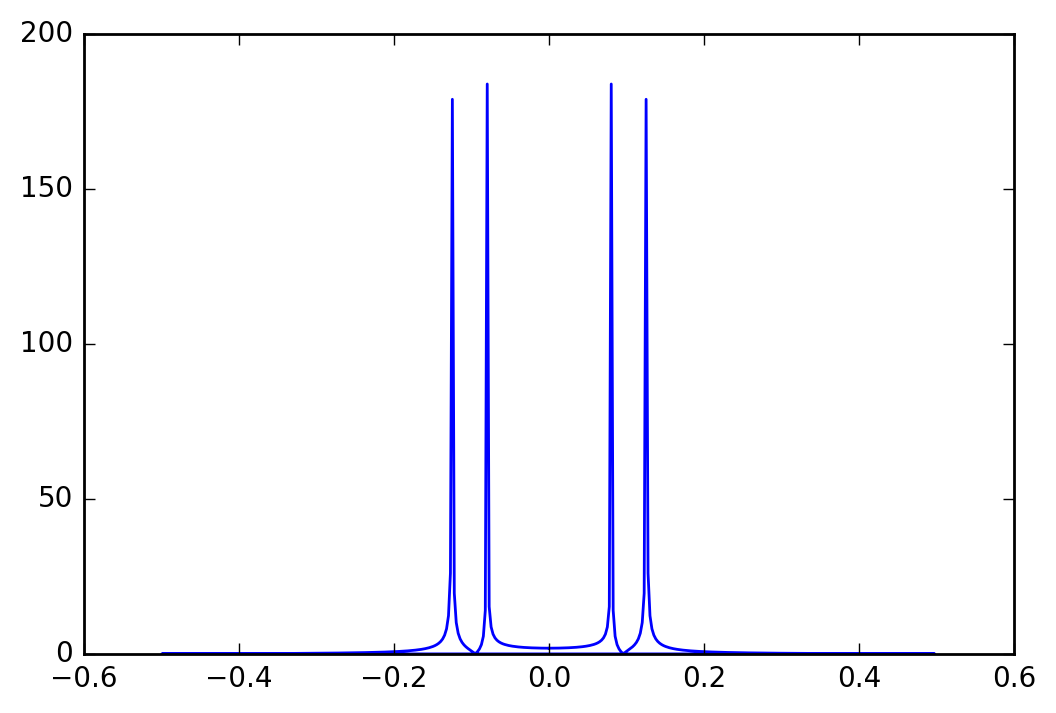

In [63]:
import numpy.fft as fft
with h5py.File(optfile,'r') as hf:
    idx = np.argmin(hf.get('error'))
    uks1 = np.array(hf.get('uks'))[idx]
spectrum = fft.fft(uks1[0])
freq = fft.fftfreq(len(spectrum))
plot(freq, abs(spectrum))
threshold = 0.5 * max(abs(spectrum))
mask = abs(spectrum) > threshold
peaks = freq[mask]
print 40*peaks
print np.argmax(abs(spectrum))
spectrum[np.argmax(abs(spectrum))] = 0
spectrum[np.argmax(abs(spectrum))] = 0

modi = fft.ifft(spectrum)
figure()
plot(modi)
figure()
spectrum = fft.fft(modi)
freq = fft.fftfreq(len(spectrum))
plot(freq, abs(spectrum))
threshold = 0.5 * max(abs(spectrum))
mask = abs(spectrum) > threshold
peaks = freq[mask]
print 40*peaks
figure()
plot(uks1[0])
figure()
with h5py.File(datafile,'r') as hf:
    idx = np.argmin(hf.get('error'))
    uks1 = np.array(hf.get('uks'))[idx]
spectrum = fft.fft(uks1[0])
freq = fft.fftfreq(len(spectrum))
plot(freq, abs(spectrum))
threshold = 0.5 * max(abs(spectrum))
mask = abs(spectrum) > threshold
peaks = freq[mask]
print 40*peaks

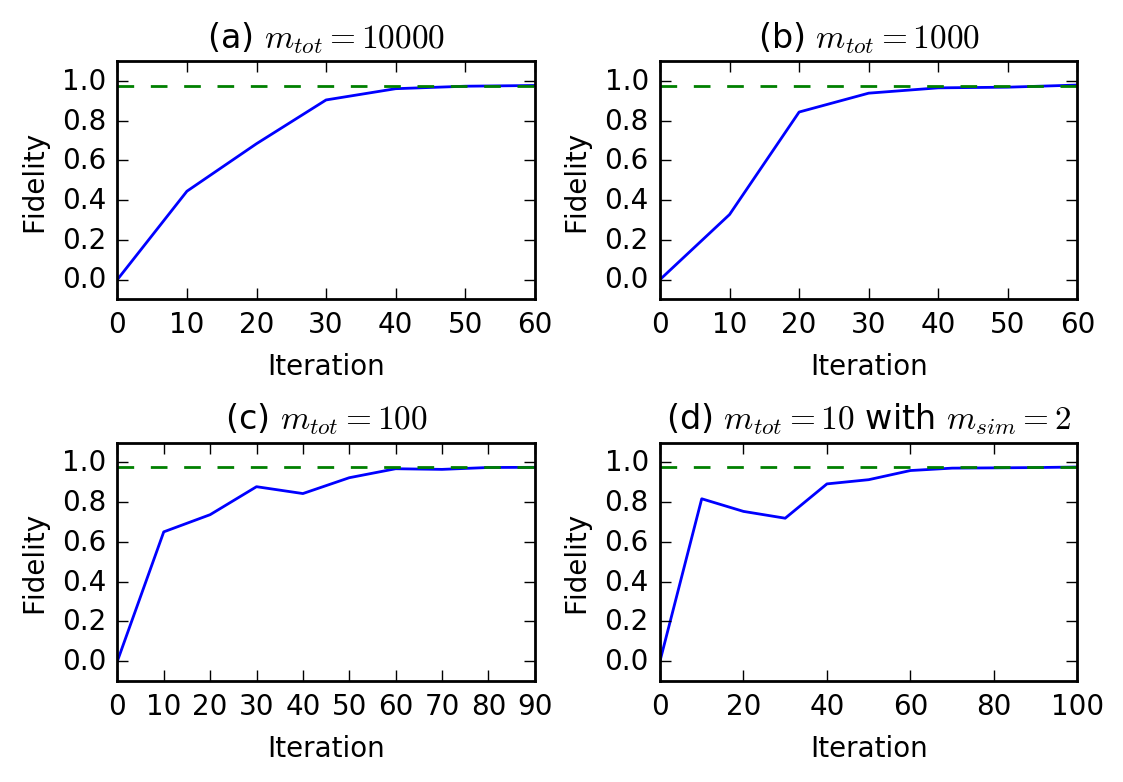

In [54]:
err1 = np.load("err1.npy")
err2 = np.load("err2.npy")
err3 = np.load("err3.npy")
err4 = np.load("err4.npy")

#plot(np.arange(len(err1)),err1)
#plot(np.arange(len(err2)),err2)
#plot(np.arange(len(err3)),err3)
#plot(np.arange(len(err4)),err4)

np.save("err1",err1)
np.save("err2",err2)
np.save("err3",err3)
np.save("err4",err4)
err1[0] = 0
err2[0] = 0
err3[0] = 0
err4[0] = 0
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
err1[0] = 0
# Create 2x2 sub plots
gs = gridspec.GridSpec(2,2)
gs.update(left=1, right=3, wspace=0.3, hspace=0.6)
fig_height = 4
plot_aspect_ratio = 0.6
pl.figure(figsize=(fig_height  * plot_aspect_ratio, fig_height ))
ax = pl.subplot(gs[0, 0]) # row 0, col 0
pl.plot(10*np.arange(len(err4)),err4)
tar = 0.975 *np.ones(len(err4))
pl.plot(10*np.arange(len(err4)),tar, linestyle='--')

pl.xlabel("Iteration")
pl.ylabel("Fidelity")
pl.ylim(ymax=1.1)
pl.ylim(ymin=-0.1)
pl.title("(a) $m_{tot} = 10000$" )

ax = pl.subplot(gs[0, 1]) # row 0, col 0
pl.plot(10*np.arange(len(err3)),err3)
tar = 0.975 *np.ones(len(err3))
pl.plot(10*np.arange(len(err3)),tar, linestyle='--')

pl.xlabel("Iteration")
pl.ylabel("Fidelity")
pl.ylim(ymax=1.1)
pl.ylim(ymin=-0.1)
pl.title("(b) $m_{tot} = 1000$" )


ax = pl.subplot(gs[1, 0]) # row 0, col 0
pl.plot(10*np.arange(len(err2)),err2)
tar = 0.975 *np.ones(len(err2))
pl.plot(10*np.arange(len(err2)),tar, linestyle='--')

pl.xlabel("Iteration")
pl.ylabel("Fidelity")
pl.ylim(ymax=1.1)
pl.ylim(ymin=-0.1)
pl.title("(c) $m_{tot} = 100$" )

ax = pl.subplot(gs[1, 1]) # row 0, col 0
pl.plot(10*np.arange(len(err1)),err1)
tar = 0.975 *np.ones(len(err1))
pl.plot(10*np.arange(len(err1)),tar, linestyle='--')

pl.xlabel("Iteration")
pl.ylabel("Fidelity")
pl.ylim(ymax=1.1)
pl.ylim(ymin=-0.1)
pl.title("(d) $m_{tot} = 10$ with $m_{sim} = 2$" )

In [2]:
datafile = '/home/mohamed/Data/01085_Qubit_Pi_open.h5'
datafile = '/home/mohamed/Data/01136_Qubit_Pi_open.h5'

gs0 = np.load(str(datafile)+"_g.npy")
es0 = np.load(str(datafile)+"_e.npy")
with h5py.File(datafile,'r') as hf:
    uks0 =  np.array(hf.get('uks'))[-1]
datafile = '/home/mohamed/Data/01129_Qubit_Pi_open.h5'
gs1 = np.load(str(datafile)+"_g.npy")
es1 = np.load(str(datafile)+"_e.npy")
with h5py.File(datafile,'r') as hf:
    uks1 = np.array(hf.get('uks'))[-1]
datafile = '/home/mohamed/Data/01132_Qubit_Pi_open.h5'
gs2 = np.load(str(datafile)+"_g.npy")
es2 = np.load(str(datafile)+"_e.npy")
with h5py.File(datafile,'r') as hf:
    uks2 = np.array(hf.get('uks'))[-1]
tlist = np.load(str(datafile)+"_t.npy")

tlist2 = tlist
uks_t0 = np.zeros((uks1.shape[0],1))
uks0 = np.hstack([uks0,uks_t0])
uks1 = np.hstack([uks1,uks_t0])
uks2 = np.hstack([uks2,uks_t0])

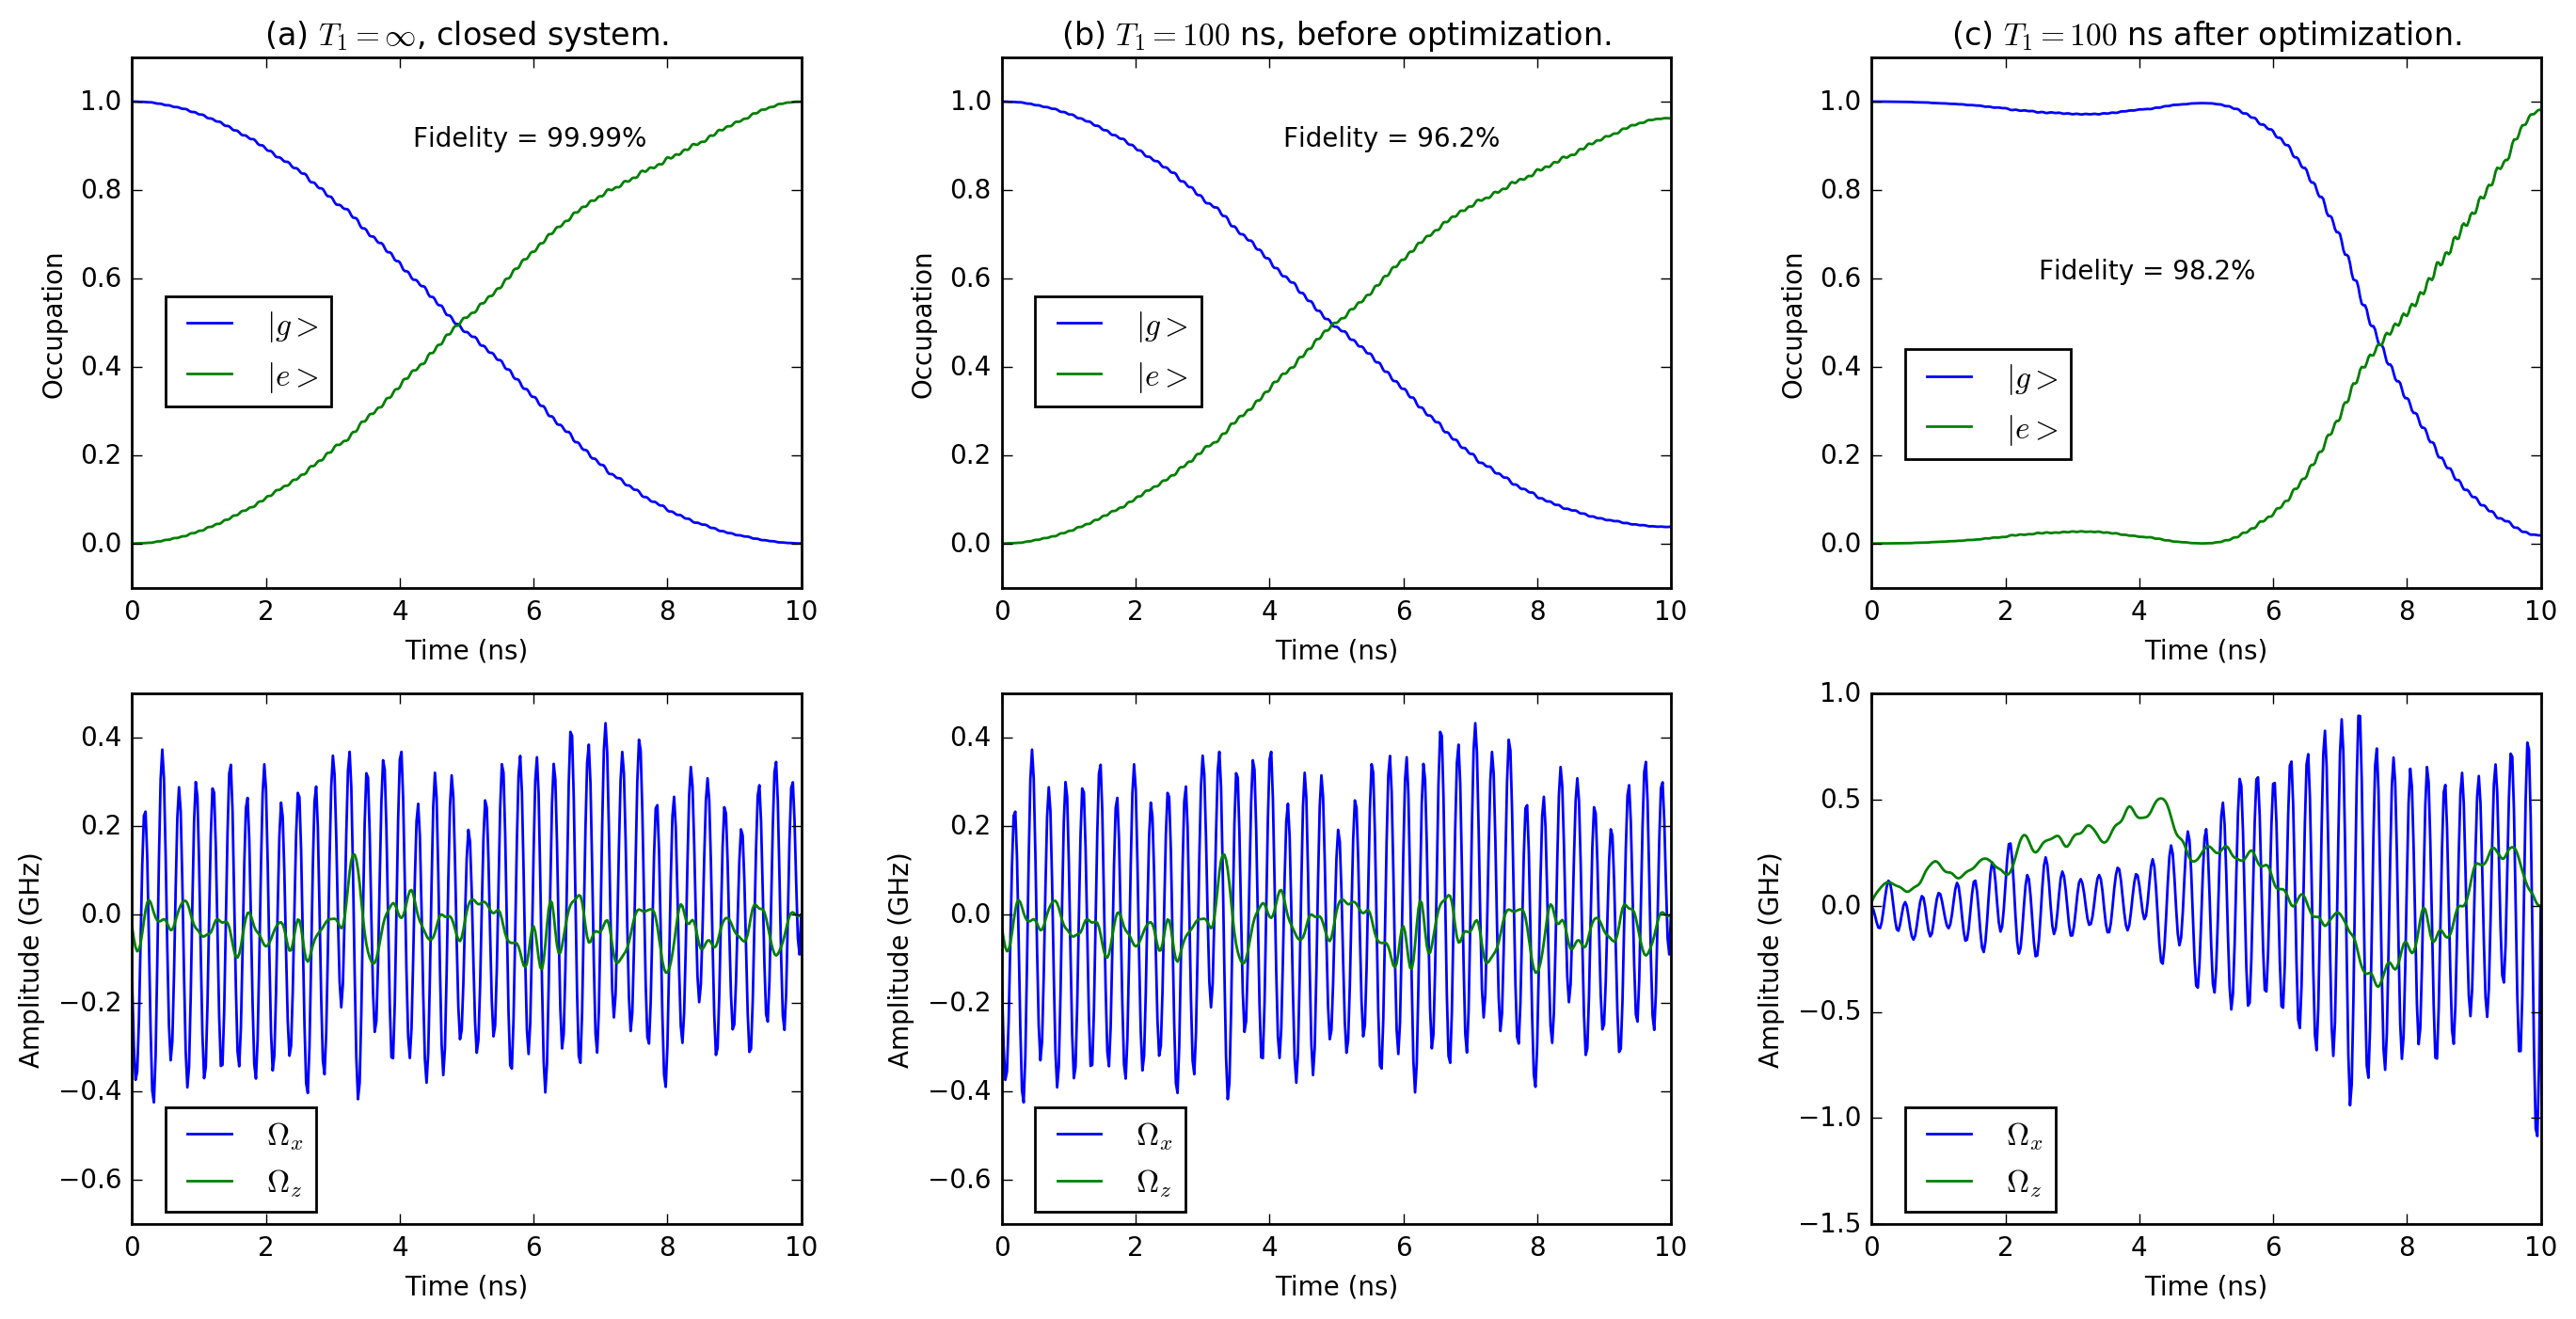

In [3]:
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec

# Create 2x2 sub plots
gs = gridspec.GridSpec(2,3)
gs.update(left=1, right=3, wspace=0.3)
fig_height = 8
plot_aspect_ratio = 0.8
pl.figure(figsize=(fig_height  * plot_aspect_ratio, fig_height ))
ax = pl.subplot(gs[0, 2]) # row 0, col 0
pl.plot(tlist,gs0, label ="$|g>$")
pl.plot(tlist,es0, label ="$|e>$")
pl.xlabel("Time (ns)")
pl.ylabel("Occupation")
pl.ylim(ymax=1.1)
pl.ylim(ymin=-0.1)
pl.legend(bbox_to_anchor=(0.05, 0.45), loc=2, borderaxespad=0., prop={'size': 12})
ax.text(2.5, 0.6, "Fidelity = 98.2%", fontsize=10)

pl.title("(c) $T_1 = 100 $ ns after optimization." )
ax = pl.subplot(gs[0, 0]) # row 0, col 1
pl.plot(tlist,gs1, label ="$|g>$")
pl.plot(tlist,es1, label ="$|e>$")
pl.xlabel("Time (ns)")
pl.ylabel("Occupation")
pl.ylim(ymax=1.1)
pl.ylim(ymin=-0.1)

pl.title("(a) $T_1 = \infty $, closed system.")
ax.text(4.2, 0.9, "Fidelity = 99.99%", fontsize=10)

pl.legend(bbox_to_anchor=(0.05, 0.55), loc=2, borderaxespad=0., prop={'size': 12})

ax = pl.subplot(gs[0,1]) # row 1, span all columns
pl.plot(tlist,gs2, label ="$|g>$")
pl.plot(tlist,es2, label ="$|e>$")
pl.xlabel("Time (ns)")
pl.ylabel("Occupation")
pl.title("(b) $T_1 = 100 $ ns, before optimization.")
ax.text(4.2, 0.9, "Fidelity = 96.2%", fontsize=10)
pl.ylim(ymax=1.1)
pl.ylim(ymin=-0.1)
pl.legend(bbox_to_anchor=(0.05, 0.55), loc=2, borderaxespad=0., prop={'size': 12})
ax = pl.subplot(gs[1, 2]) # row 0, col 0
pl.plot(tlist2,uks0[0], label ="$\Omega_x$")
pl.plot(tlist2,uks0[1], label ="$\Omega_z$")
pl.xlabel("Time (ns)")
pl.ylabel("Amplitude (GHz)")
pl.legend(bbox_to_anchor=(0.05, 0.22), loc=2, borderaxespad=0., prop={'size': 12})

ax = pl.subplot(gs[1, 1]) # row 0, col 0
pl.plot(tlist2,uks2[0], label ="$\Omega_x$")
pl.plot(tlist2,uks2[1], label ="$\Omega_z$")
pl.xlabel("Time (ns)")
pl.ylabel("Amplitude (GHz)")
pl.ylim(ymin=-0.7)
pl.legend(bbox_to_anchor=(0.05, 0.22), loc=2, borderaxespad=0., prop={'size': 12})

ax = pl.subplot(gs[1, 0]) # row 0, col 0
pl.plot(tlist2,uks1[0], label ="$\Omega_x$")
pl.plot(tlist2,uks1[1], label ="$\Omega_z$")
pl.xlabel("Time (ns)")
pl.ylabel("Amplitude (GHz)")
pl.ylim(ymin=-0.7)
pl.legend(bbox_to_anchor=(0.05, 0.22), loc=2, borderaxespad=0., prop={'size': 12})



In [18]:
datafile = '/home/mohamed/Data/01093_Qubit_Pi_open.h5'
gs0 = np.load(str(datafile)+"_g.npy")
es0 = np.load(str(datafile)+"_e.npy")
with h5py.File(datafile,'r') as hf:
    uks0 = list((hf.get('uks'))[-1])
datafile = '/home/mohamed/Data/01089_Qubit_Pi_open.h5'
gs1 = np.load(str(datafile)+"_g.npy")
es1 = np.load(str(datafile)+"_e.npy")
with h5py.File(datafile,'r') as hf:
    uks1 = list((hf.get('uks'))[-1])
datafile = '/home/mohamed/Data/01095_Qubit_Pi_open.h5'
gs2 = np.load(str(datafile)+"_g.npy")
es2 = np.load(str(datafile)+"_e.npy")
with h5py.File(datafile,'r') as hf:
    uks2 = list((hf.get('uks'))[-1])
tlist = np.load(str(datafile)+"_t.npy")

tlist2 = tlist[:len(tlist)-1]
print np.shape(tlist)

(401,)


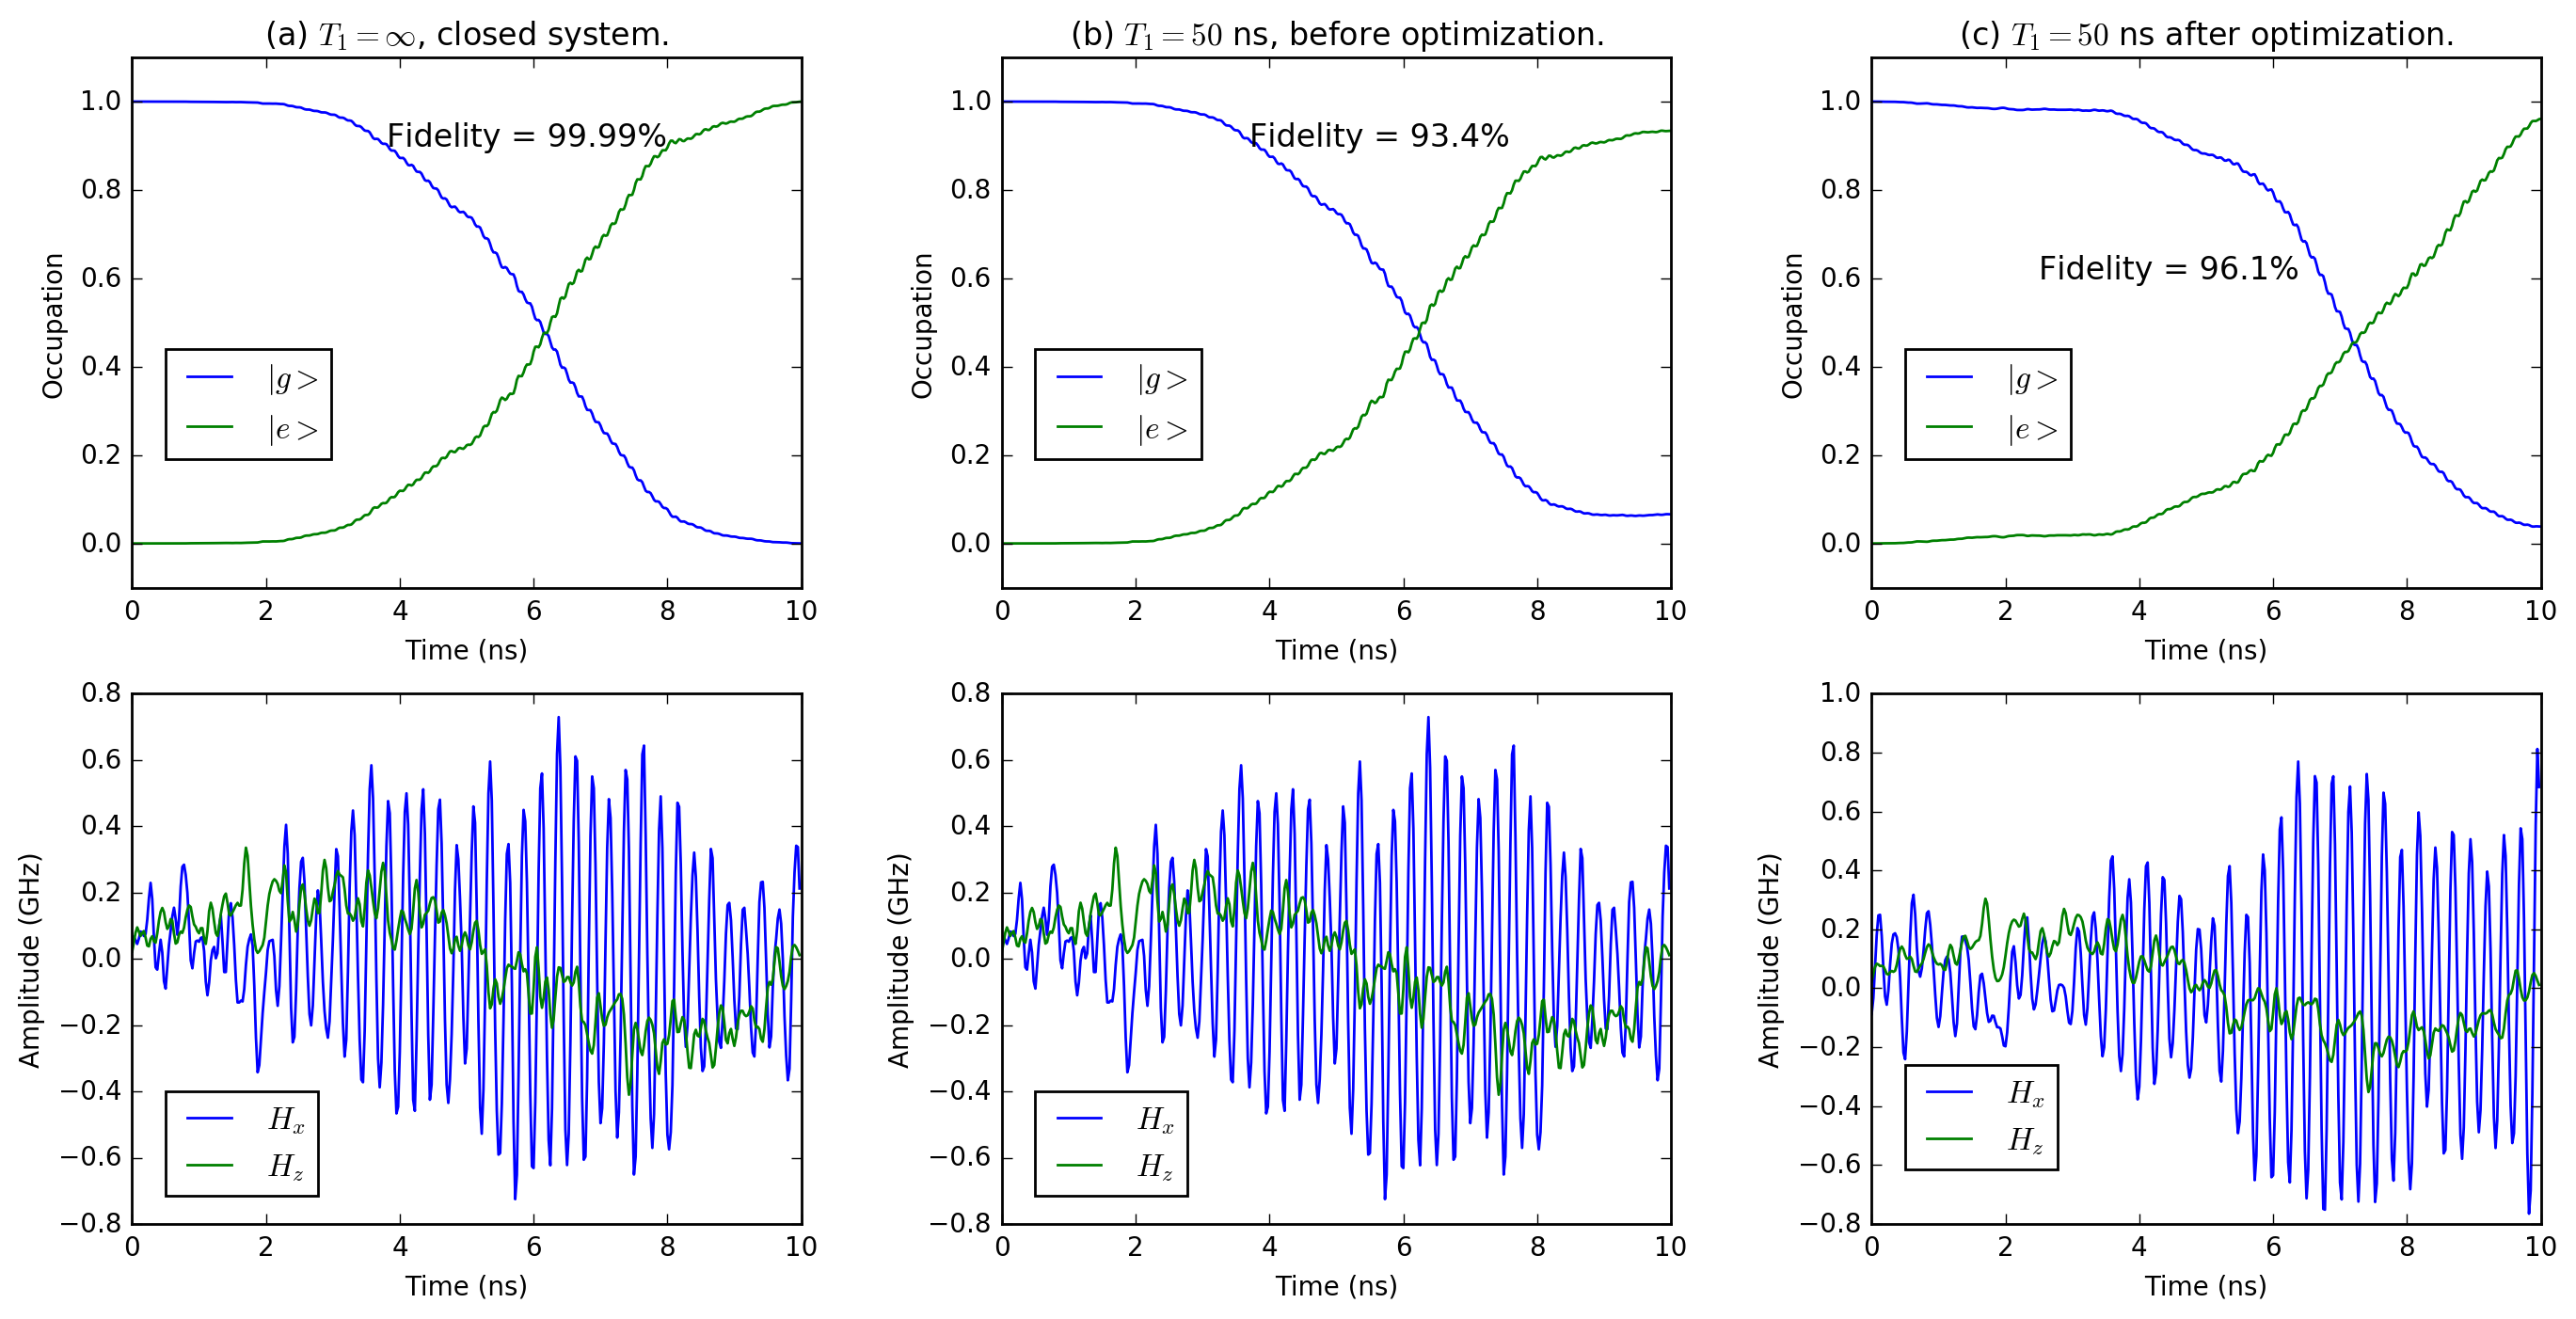

In [140]:
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec

# Create 2x2 sub plots
gs = gridspec.GridSpec(2,3)
gs.update(left=1, right=3, wspace=0.3)
fig_height = 8
plot_aspect_ratio = 0.8
pl.figure(figsize=(fig_height  * plot_aspect_ratio, fig_height ))
ax = pl.subplot(gs[0, 2]) # row 0, col 0
pl.plot(tlist,gs0, label ="$|g>$")
pl.plot(tlist,es0, label ="$|e>$")
pl.xlabel("Time (ns)")
pl.ylabel("Occupation")
pl.ylim(ymax=1.1)
pl.ylim(ymin=-0.1)
pl.legend(bbox_to_anchor=(0.05, 0.45), loc=2, borderaxespad=0., prop={'size': 12})
ax.text(2.5, 0.6, "Fidelity = 96.1%", fontsize=12)

pl.title("(c) $T_1 = 50 $ ns after optimization." )
ax = pl.subplot(gs[0, 0]) # row 0, col 1
pl.plot(tlist,gs1, label ="$|g>$")
pl.plot(tlist,es1, label ="$|e>$")
pl.xlabel("Time (ns)")
pl.ylabel("Occupation")
pl.ylim(ymax=1.1)
pl.ylim(ymin=-0.1)

pl.title("(a) $T_1 = \infty $, closed system.")
ax.text(3.8, 0.9, "Fidelity = 99.99%", fontsize=12)

pl.legend(bbox_to_anchor=(0.05, 0.45), loc=2, borderaxespad=0., prop={'size': 12})

ax = pl.subplot(gs[0,1]) # row 1, span all columns
pl.plot(tlist,gs2, label ="$|g>$")
pl.plot(tlist,es2, label ="$|e>$")
pl.xlabel("Time (ns)")
pl.ylabel("Occupation")
pl.title("(b) $T_1 = 50 $ ns, before optimization.")
ax.text(3.7, 0.9, "Fidelity = 93.4%", fontsize=12)
pl.ylim(ymax=1.1)
pl.ylim(ymin=-0.1)
pl.legend(bbox_to_anchor=(0.05, 0.45), loc=2, borderaxespad=0., prop={'size': 12})
ax = pl.subplot(gs[1, 2]) # row 0, col 0
pl.plot(tlist2,uks0[0], label ="$H_x$")
pl.plot(tlist2,uks0[1], label ="$H_z$")
pl.xlabel("Time (ns)")
pl.ylabel("Amplitude (GHz)")
pl.legend(bbox_to_anchor=(0.05, 0.3), loc=2, borderaxespad=0., prop={'size': 12})

ax = pl.subplot(gs[1, 1]) # row 0, col 0
pl.plot(tlist2,uks2[0], label ="$H_x$")
pl.plot(tlist2,uks2[1], label ="$H_z$")
pl.xlabel("Time (ns)")
pl.ylabel("Amplitude (GHz)")
pl.legend(bbox_to_anchor=(0.05, 0.25), loc=2, borderaxespad=0., prop={'size': 12})

ax = pl.subplot(gs[1, 0]) # row 0, col 0
pl.plot(tlist2,uks1[0], label ="$H_x$")
pl.plot(tlist2,uks1[1], label ="$H_z$")
pl.xlabel("Time (ns)")
pl.ylabel("Amplitude (GHz)")
pl.legend(bbox_to_anchor=(0.05, 0.25), loc=2, borderaxespad=0., prop={'size': 12})



In [13]:
#T1 = 100000
datafile = "/home/mohamed/Data/01100_Qubit_Pi_open.h5"
with h5py.File(datafile,'r') as hf:
    js = list((hf.get('norm')))
print js
print js[-1]/js[0]

[array([ 1.00006092], dtype=float32), array([ 1.00006855], dtype=float32), array([ 1.0000608], dtype=float32), array([ 1.0000391], dtype=float32), array([ 1.00001585], dtype=float32), array([ 1.00001574], dtype=float32), array([ 1.00001228], dtype=float32), array([ 1.00001538], dtype=float32), array([ 1.00001454], dtype=float32)]
[ 0.99995363]


In [66]:
#T1 = 10000
datafile = "/home/mohamed/Data/01101_Qubit_Pi_open.h5"
with h5py.File(datafile,'r') as hf:
    js = list((hf.get('norm')))
print js
print np.min(js)/js[0]

[array([ 1.00006151], dtype=float32), array([ 1.00006032], dtype=float32), array([ 1.00003314], dtype=float32), array([ 0.99984306], dtype=float32), array([ 0.99964368], dtype=float32), array([ 0.999587], dtype=float32), array([ 0.99956721], dtype=float32), array([ 0.99956071], dtype=float32), array([ 0.99956119], dtype=float32), array([ 0.99955833], dtype=float32), array([ 0.99955487], dtype=float32), array([ 0.99955785], dtype=float32), array([ 0.99955344], dtype=float32), array([ 0.9995594], dtype=float32)]
[ 0.99949199]


In [65]:
#T1 = 1000
datafile = "/home/mohamed/Data/01102_Qubit_Pi_open.h5"
with h5py.File(datafile,'r') as hf:
    js = list((hf.get('norm')))
print js
print np.min(js)/js[0]

[array([ 1.00006235], dtype=float32), array([ 1.00006139], dtype=float32), array([ 0.99999833], dtype=float32), array([ 0.9992817], dtype=float32), array([ 0.99685311], dtype=float32), array([ 0.99547076], dtype=float32), array([ 0.99506074], dtype=float32), array([ 0.99493319], dtype=float32), array([ 0.99489158], dtype=float32), array([ 0.99487567], dtype=float32), array([ 0.99487501], dtype=float32), array([ 0.99486816], dtype=float32), array([ 0.99486154], dtype=float32)]
[ 0.99479949]


In [64]:
#T1 = 500
datafile = "/home/mohamed/Data/01103_Qubit_Pi_open.h5"
with h5py.File(datafile,'r') as hf:
    js = list((hf.get('norm')))
print js
print np.min(js)/js[0]

[array([ 1.00006056], dtype=float32), array([ 1.00003624], dtype=float32), array([ 0.99967897], dtype=float32), array([ 0.99663663], dtype=float32), array([ 0.9920705], dtype=float32), array([ 0.99042106], dtype=float32), array([ 0.98994249], dtype=float32), array([ 0.98979056], dtype=float32), array([ 0.98973012], dtype=float32), array([ 0.98972607], dtype=float32), array([ 0.98972714], dtype=float32), array([ 0.98972201], dtype=float32), array([ 0.98972631], dtype=float32), array([ 0.98972803], dtype=float32)]
[ 0.98966211]


In [63]:
#T1 = 250
datafile = "/home/mohamed/Data/01104_Qubit_Pi_open.h5"
with h5py.File(datafile,'r') as hf:
    js = list((hf.get('norm')))
print js
print np.min(js)/js[0]

[array([ 0.999982], dtype=float32), array([ 0.99631166], dtype=float32), array([ 0.98175883], dtype=float32), array([ 0.97959745], dtype=float32), array([ 0.97935635], dtype=float32), array([ 0.97934937], dtype=float32), array([ 0.97936928], dtype=float32), array([ 0.97940165], dtype=float32), array([ 0.97942966], dtype=float32), array([ 0.97946399], dtype=float32), array([ 0.97949821], dtype=float32), array([ 0.97952992], dtype=float32), array([ 0.9795627], dtype=float32), array([ 0.97958964], dtype=float32), array([ 0.97962344], dtype=float32), array([ 0.97964823], dtype=float32), array([ 0.97967708], dtype=float32), array([ 0.979711], dtype=float32)]
[ 0.97936702]


In [62]:
#T1 = 100
datafile = "/home/mohamed/Data/01105_Qubit_Pi_open.h5"
with h5py.File(datafile,'r') as hf:
    js = list((hf.get('norm')))
print js
print np.min(js)/js[0]

[array([ 0.99993294], dtype=float32), array([ 0.99269152], dtype=float32), array([ 0.95599324], dtype=float32), array([ 0.94975257], dtype=float32), array([ 0.94911897], dtype=float32), array([ 0.9491871], dtype=float32), array([ 0.94935673], dtype=float32)]
[ 0.94918263]


In [67]:
#T1 = 50
datafile = "/home/mohamed/Data/01106_Qubit_Pi_open.h5"
with h5py.File(datafile,'r') as hf:
    js = list((hf.get('norm')))
print js
print np.min(js)/js[0]

[array([ 0.9995268], dtype=float32), array([ 0.961402], dtype=float32), array([ 0.90639776], dtype=float32), array([ 0.90049225], dtype=float32), array([ 0.90033245], dtype=float32), array([ 0.90094757], dtype=float32), array([ 0.90160602], dtype=float32), array([ 0.90227252], dtype=float32), array([ 0.90298921], dtype=float32), array([ 0.90366948], dtype=float32)]
[ 0.90075868]


In [77]:
#T1 = 20
datafile = "/home/mohamed/Data/01107_Qubit_Pi_open.h5"
with h5py.File(datafile,'r') as hf:
    js = list((hf.get('norm')))
print js
print np.min(js)/js[0]

[array([ 0.99977344], dtype=float32), array([ 0.97431213], dtype=float32), array([ 0.8004235], dtype=float32), array([ 0.76814866], dtype=float32), array([ 0.76719201], dtype=float32), array([ 0.77026397], dtype=float32)]
[ 0.76736587]


In [86]:
#T1 = 10
datafile = "/home/mohamed/Data/01108_Qubit_Pi_open.h5"
with h5py.File(datafile,'r') as hf:
    js = list((hf.get('norm')))
print js
print np.min(js)/js[0]

[array([ 0.99778175], dtype=float32), array([ 0.84717351], dtype=float32), array([ 0.60810125], dtype=float32), array([ 0.58525223], dtype=float32), array([ 0.58997768], dtype=float32), array([ 0.59907174], dtype=float32)]
[ 0.58655334]


In [98]:
#T1 = 5
datafile = "/home/mohamed/Data/01110_Qubit_Pi_open.h5"
with h5py.File(datafile,'r') as hf:
    js = list((hf.get('norm')))
print js
print np.min(js)/js[0]

[array([ 0.99922144], dtype=float32), array([ 0.89951104], dtype=float32), array([ 0.39093745], dtype=float32), array([ 0.31678429], dtype=float32), array([ 0.31860366], dtype=float32), array([ 0.3319906], dtype=float32)]
[ 0.31703112]


[0.99995136, 0.99949199, 0.99479949, 0.98966211, 0.97936702, 0.94918263, 0.90075868, 0.76736587, 0.58655334, 0.31703112]


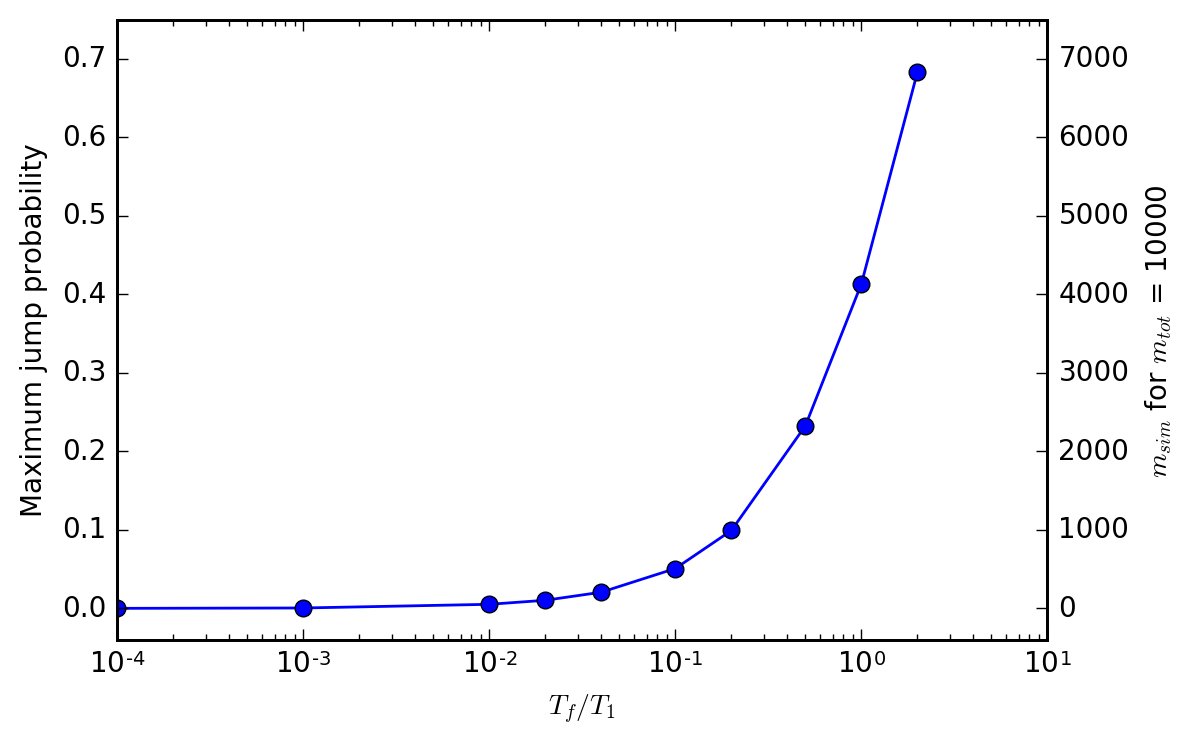

In [5]:
T1s = [100000,10000,1000,500,250,100,50,20,10,5]
tf = 10.0

T1s = [tf/x for x in T1s]
num = 1100
ns = []
for ii in range (len(T1s)):
    n = num + ii
    if ii == len(T1s)-1:
        n = num + ii +1
    datafile = "/home/mohamed/Data/0"+str(n)+"_Qubit_Pi_open.h5"
    with h5py.File(datafile,'r') as hf:
        js = list((hf.get('norm')))
    ns.append((np.min(js)/js[0])[0])

print ns
ns = [1-x for x in ns]
ts = [10000*x for x in ns]
fig, ax1 = plt.subplots()

plt.xscale('log')
plt.ylim(ymax = 0.75, ymin = -0.04)
plt.xlabel("$\\frac{T_f}{T_1}$")
plt.xlabel("${T_f}/{T_1}$")
plt.ylabel("Maximum jump probability")
plt.plot (T1s,ns, marker='o')
ax2 = ax1.twinx()
ax2.set_ylim(10000*-0.04, 10000* 0.75)
ax2.set_ylabel('$m_{sim}$ for $m_{tot}$ = 10000 ')

(2, 500)


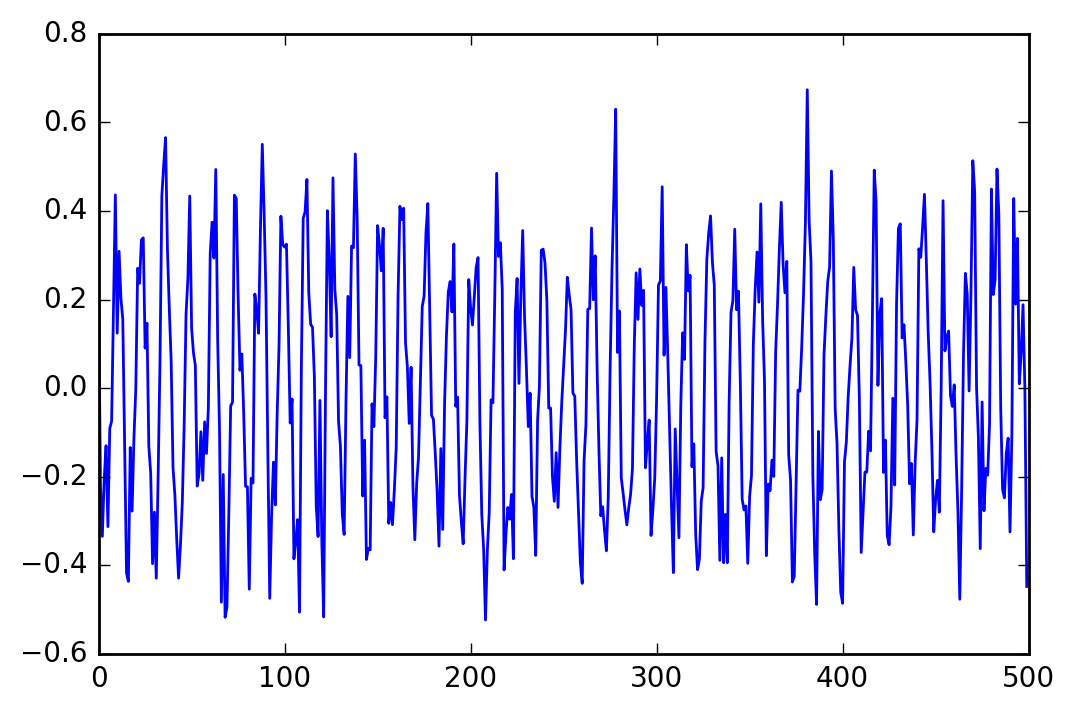

In [16]:
#100 trajs
datafile = "/home/mohamed/Data/01112_Qubit_Pi_open.h5"
with h5py.File(datafile,'r') as hf:
    js = list((hf.get('norm')))
    uks = list(hf.get('uks')[-1])
    
print np.shape(uks)
plot( np.arange(len(uks[0])),uks[0])


(2, 500)


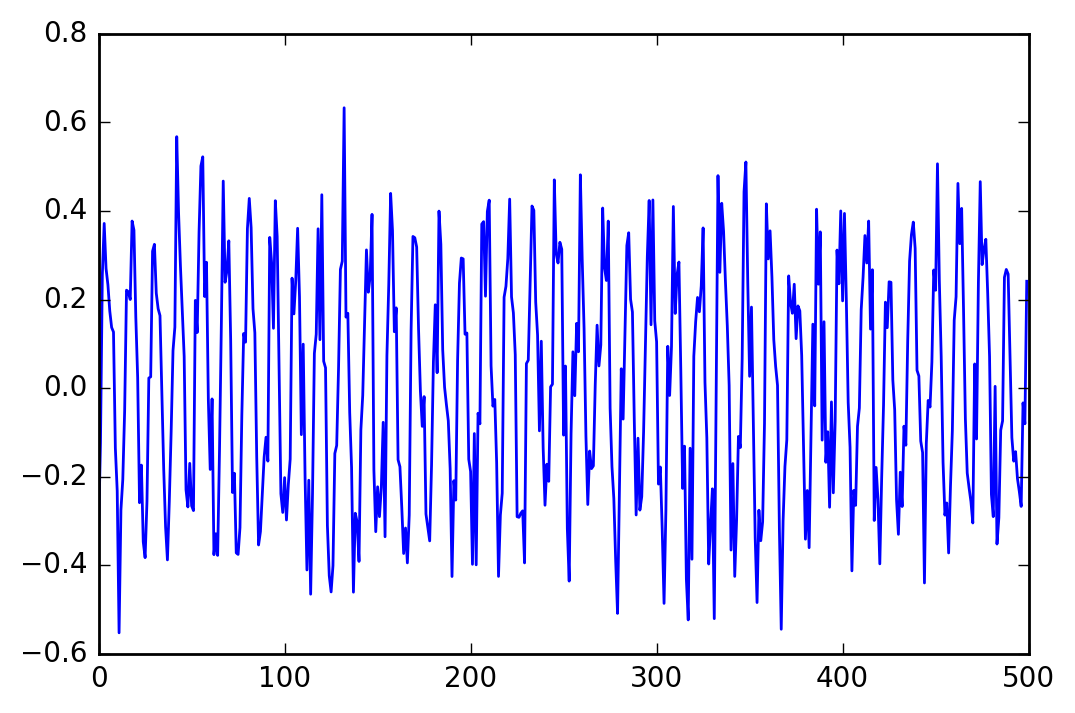

In [15]:
#10 trajs
datafile = "/home/mohamed/Data/01113_Qubit_Pi_open.h5"
with h5py.File(datafile,'r') as hf:
    js = list((hf.get('norm')))
    uks = list(hf.get('uks')[-1])
print np.shape(uks)
plot( np.arange(len(uks[0])),uks[0])

(2, 400)


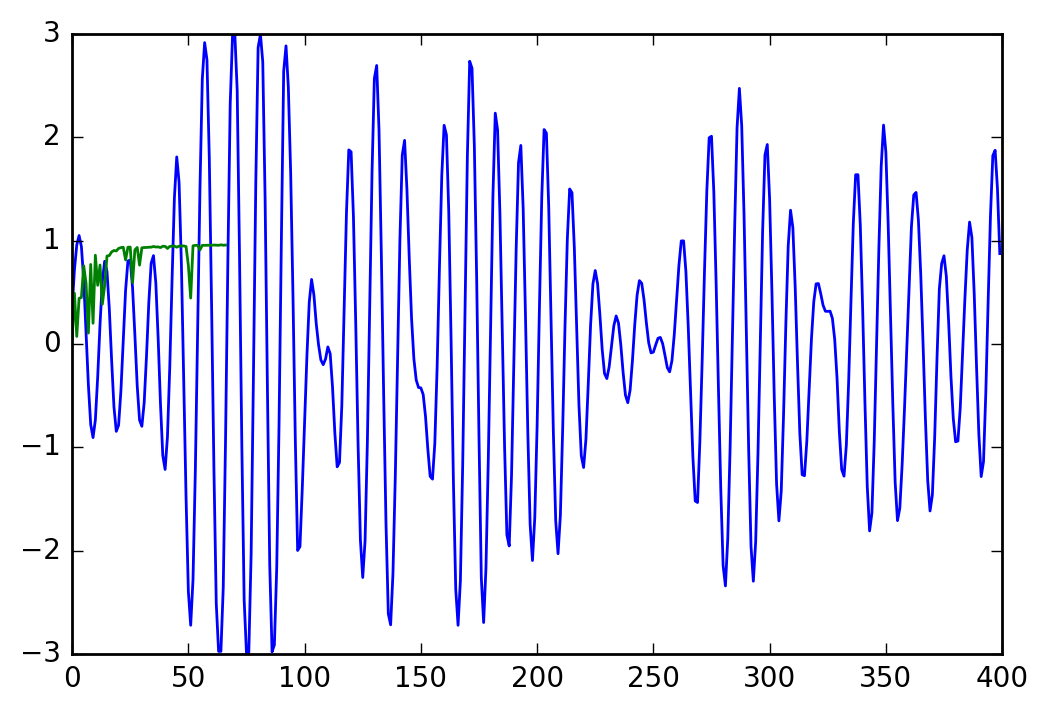

In [29]:
#1 trajs
datafile = "/home/mohamed/Data/01121_Qubit_Pi_open.h5"
with h5py.File(datafile,'r') as hf:
    js = list((hf.get('norm')))
    uks = list(hf.get('uks'))
print np.shape(uks[-1])
plot( np.arange(len(uks[-1][0])),uks[-1][0])

err = []
for ii in range (len(uks)):
    err.append(open_qutip_verification(datafile,ii))
figure()
plot(np.arange(len(err)),err)

0.0811032168531
0.444809252273
0.683793647465
0.904004865028
0.960634265024
0.973110807882
0.976781235858


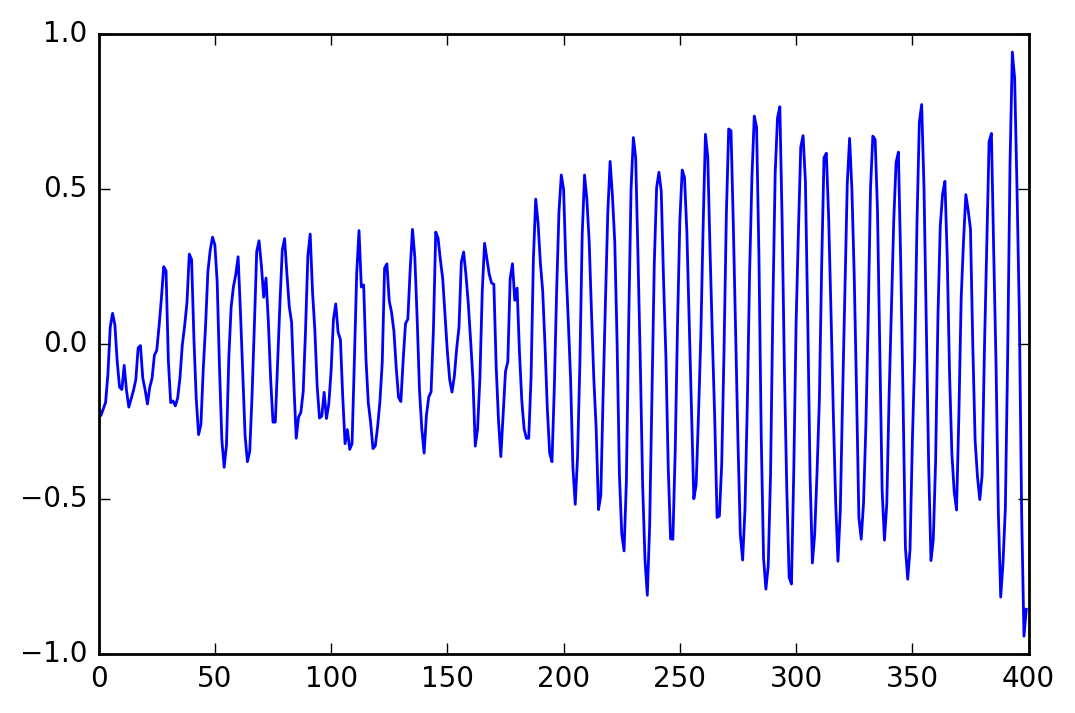

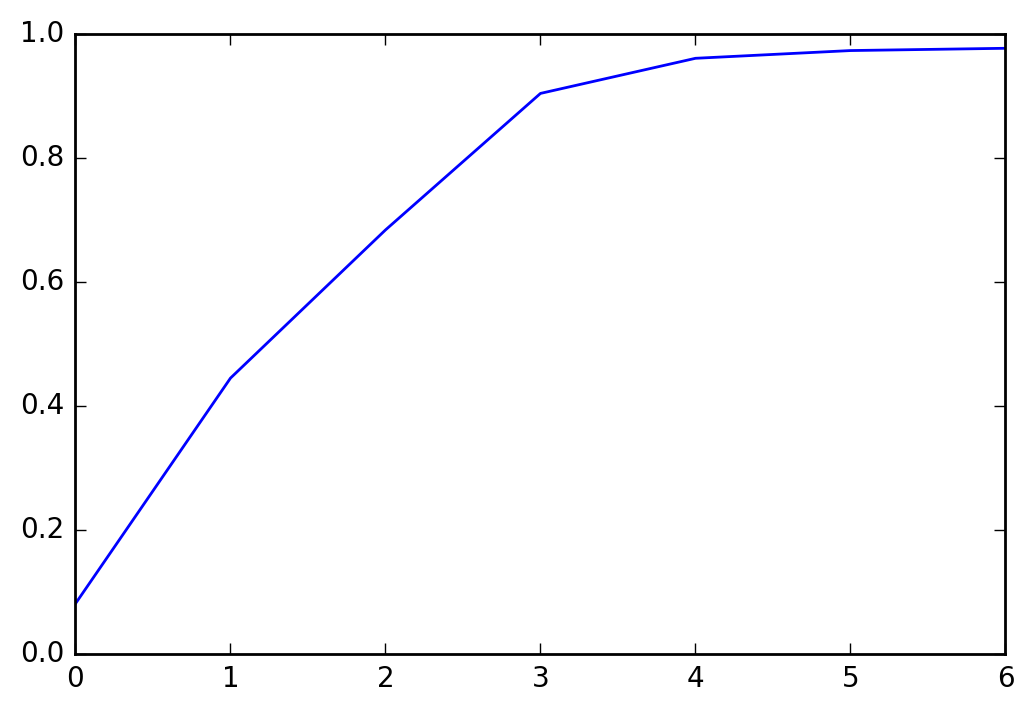

In [16]:
#1162 10000
#1164 1000
datafile = "/home/mohamed/Data/01162_Qubit_Pi_open.h5"
with h5py.File(datafile,'r') as hf:
    js = list((hf.get('norm')))
    uks = list(hf.get('uks'))
#print np.shape(uks[-1])
plot( np.arange(len(uks[-1][0])),uks[-1][0])

err4 = []
for ii in range (len(uks)):
    err4.append(open_qutip_verification(datafile,ii))
    print err4[ii]
    if err4[ii] > 0.975:
        break
    
figure()
plot(np.arange(len(err4)),err4)

(2, 400)
0.0823362241396
0.327396748508
0.843188886124
0.938147602998
0.964879427309
0.968224580168
0.979000518329


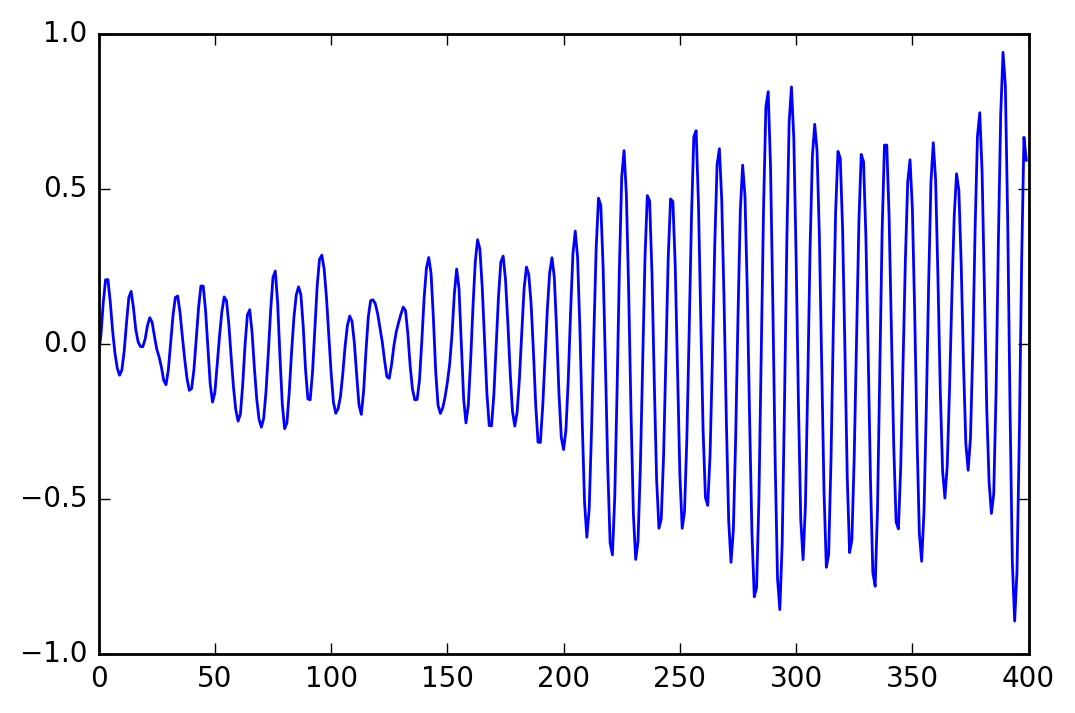

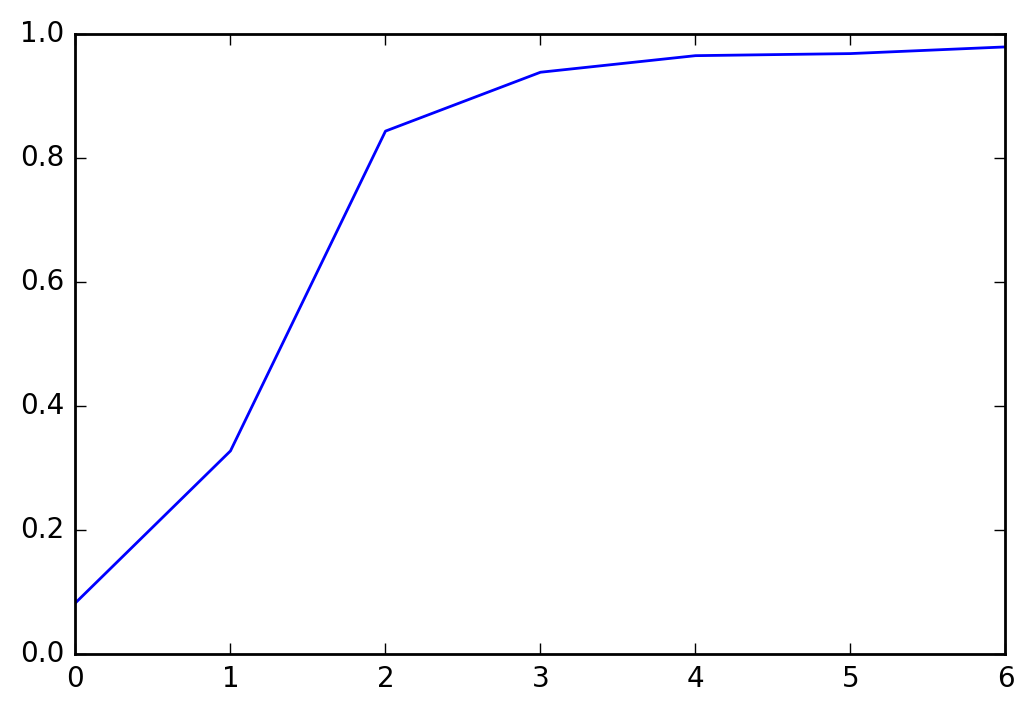

In [15]:
#1162 10000
#1165 1000
datafile = "/home/mohamed/Data/01165_Qubit_Pi_open.h5"
with h5py.File(datafile,'r') as hf:
    js = list((hf.get('norm')))
    uks = list(hf.get('uks'))
print np.shape(uks[-1])
plot( np.arange(len(uks[-1][0])),uks[-1][0])

err3 = []
for ii in range (len(uks)):
    err3.append(open_qutip_verification(datafile,ii))
    print err3[ii]
    if err3[ii] > 0.975:
        break
    
figure()
plot(np.arange(len(err3)),err3)

(2, 400)
0.00620573173148
0.650535621163
0.736974262626
0.877790763743
0.843267844534
0.922943151966
0.968156058171
0.964896217461
0.974446081683
0.975282935766


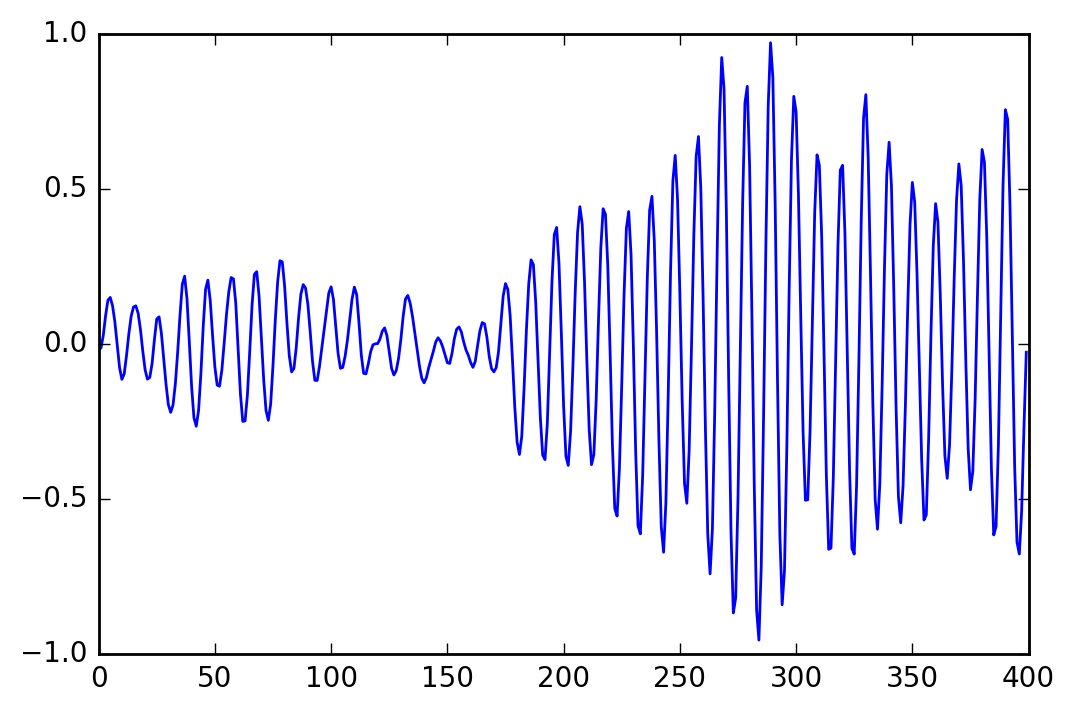

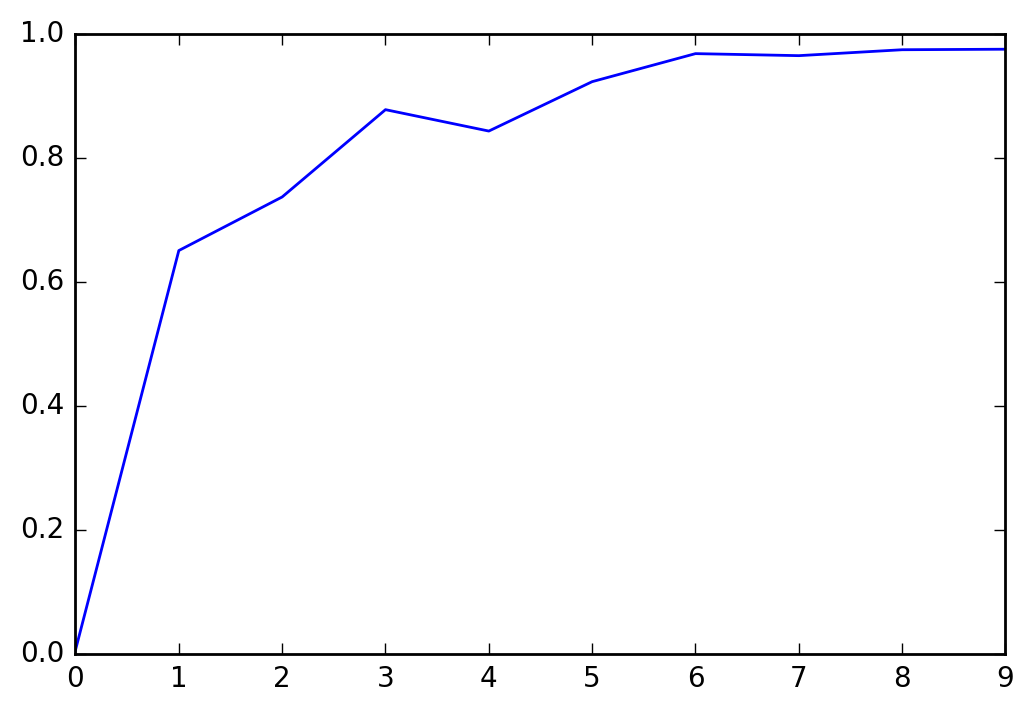

In [14]:
#1162 10000
#1165 1000
#1166 100
datafile = "/home/mohamed/Data/01168_Qubit_Pi_open.h5"
with h5py.File(datafile,'r') as hf:
    js = list((hf.get('norm')))
    uks = list(hf.get('uks'))
print np.shape(uks[-1])
plot( np.arange(len(uks[-1][0])),uks[-1][0])

err2 = []
for ii in range (len(uks)):
    err2.append(open_qutip_verification(datafile,ii))
    print err2[ii]
    if err2[ii] > 0.975:
        break
    
figure()
plot(np.arange(len(err2)),err2)

(2, 400)
0.0481490576905
0.817003844291
0.753467865734
0.719173427128
0.891865177581
0.913026329826
0.959129101999
0.97117555523
0.972542437104
0.974082313736
0.976863996111


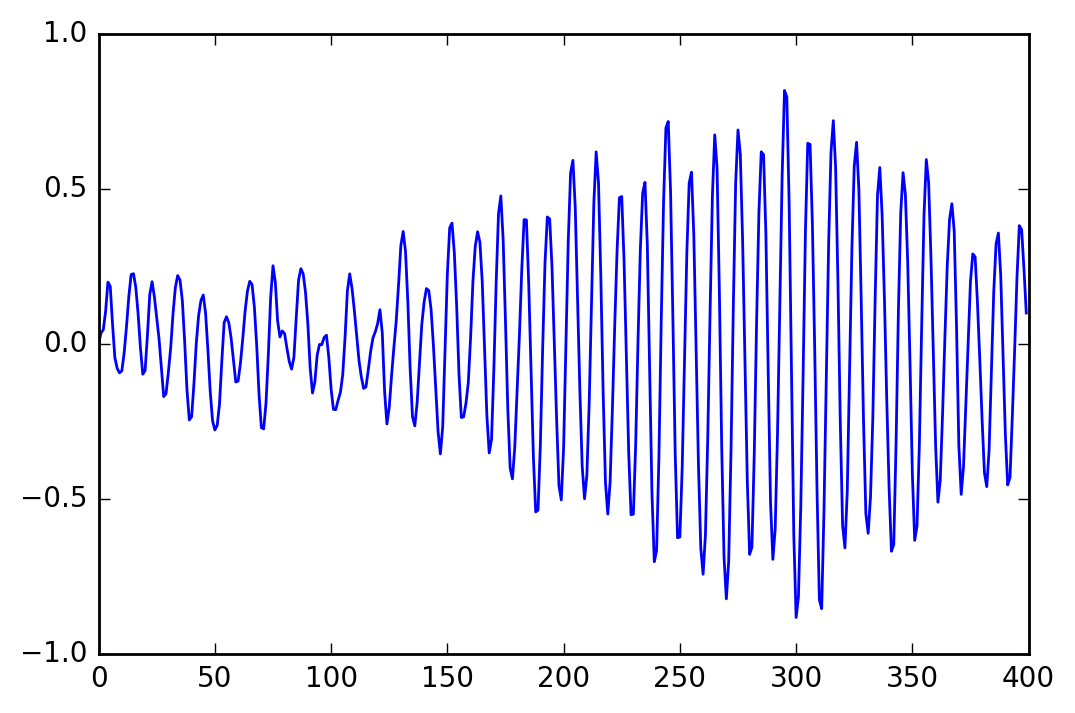

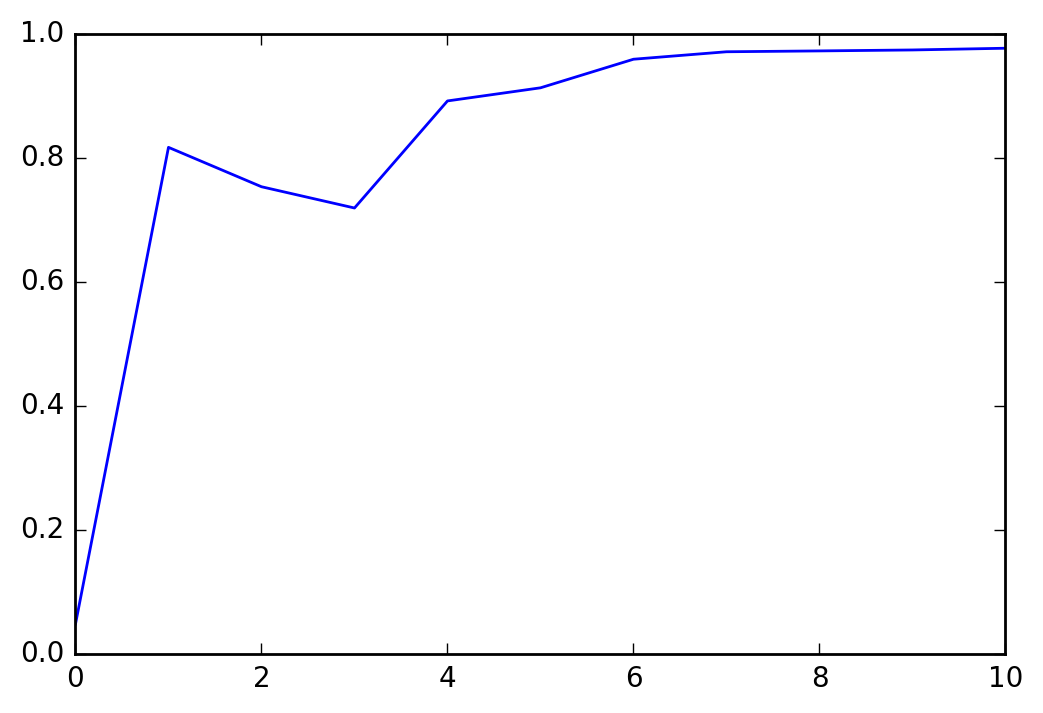

In [13]:
#1162 10000
#1165 1000
#1166 100
datafile = "/home/mohamed/Data/01171_Qubit_Pi_open.h5"
with h5py.File(datafile,'r') as hf:
    js = list((hf.get('norm')))
    uks = list(hf.get('uks'))
print np.shape(uks[-1])
plot( np.arange(len(uks[-1][0])),uks[-1][0])

err1 = []
for ii in range (len(uks)):
    err1.append(open_qutip_verification(datafile,ii))
    print err1[ii]
    if err1[ii] > 0.975:
        break
    
figure()
plot(np.arange(len(err1)),err1)

(6, 100)
0.479400382272
0.765605050673
0.962293911356
0.990089961151
0.996336575244
0.998044060698
0.998548150846
0.998701786705
0.998748832394
0.998762216813
0.998766046154
0.998767013568
0.998766730603
0.998766390438
0.998766696949
0.9987659754
0.998767239458
0.998766607641
0.998767847444
0.998767578363
0.998767649408


KeyboardInterrupt: 

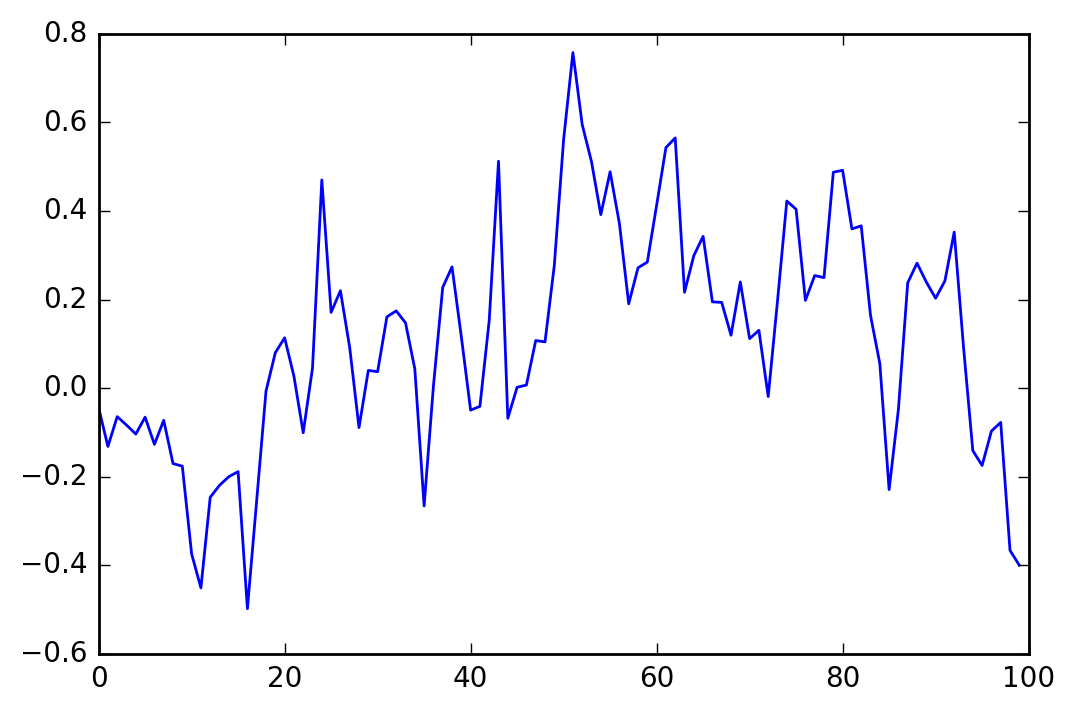

In [56]:
#1162 10000
#1165 1000
datafile = '/home/mohamed/Data/00026_GHZ.h5'

with h5py.File(datafile,'r') as hf:
    js = list((hf.get('norm')))
    uks = list(hf.get('uks'))
print np.shape(uks[-1])
plot( np.arange(len(uks[-1][0])),uks[-1][0])

err1 = []
for ii in range (len(uks)):
    err1.append(open_qutip_verification(datafile,ii))
    print err1[ii]
    if err1[ii] > 0.999 or  ii == 100:
        break
    
figure()
plot(np.arange(len(err1)),err1)

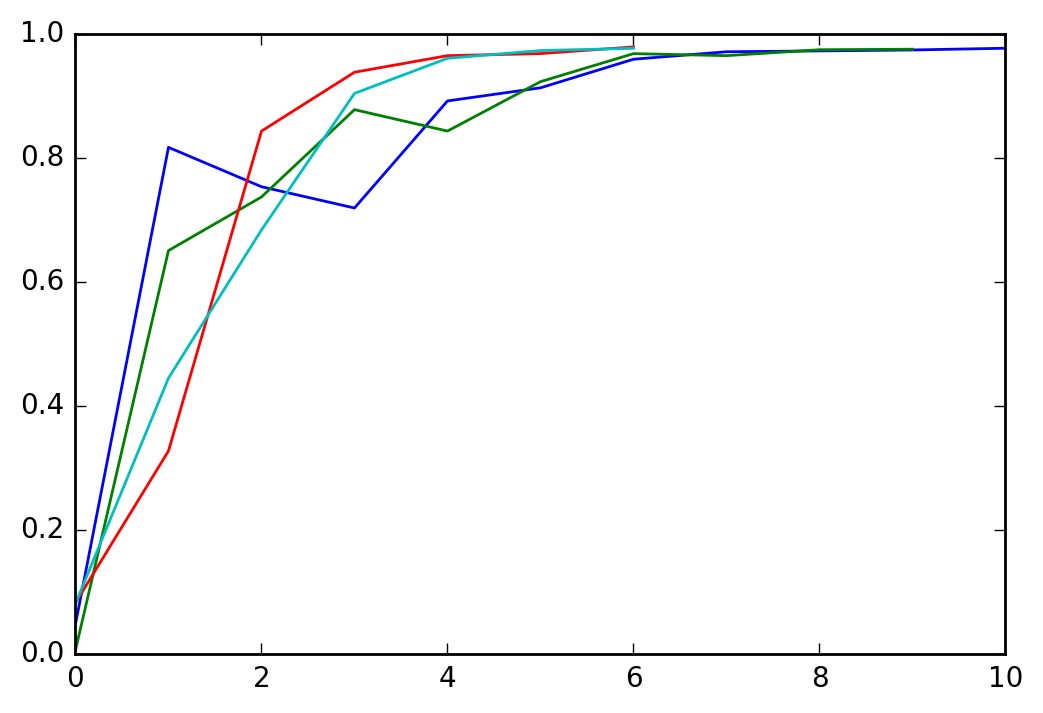

In [23]:
err1 = np.load("err1.npy")
err2 = np.load("err2.npy")
err3 = np.load("err3.npy")
err4 = np.load("err4.npy")

plot(np.arange(len(err1)),err1)
plot(np.arange(len(err2)),err2)
plot(np.arange(len(err3)),err3)
plot(np.arange(len(err4)),err4)

np.save("err1",err1)
np.save("err2",err2)
np.save("err3",err3)
np.save("err4",err4)

In [7]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import qutip as qt

def open_qutip_verification(datafile, idx):
    
    
    # load data from file
    with h5py.File(datafile,'r') as hf:
    
        gate_time = np.array(hf.get('total_time'))
        gate_steps = np.array(hf.get('steps'))
        H0 = np.array(hf.get('H0'))
        error = np.array(hf.get('error'))
        Hops = np.array(hf.get('Hops'))
        initial_vectors_c = np.array(hf.get('initial_vectors_c'))
        target_vectors_c = np.array(hf.get('target_vectors_c'))
        c_ops = np.array(hf.get('c_ops'))
        uks = np.array(hf.get('uks'))[idx]

        
    
    max_abs_diff_list = []
    all_close_list = []
    
    # H0 and Hops
    H0_qobj = qt.Qobj(H0)
    Hops_qobj = []

    for Hop in Hops:
        Hops_qobj.append(qt.Qobj(Hop))
            
            
    cops_qobj = []

    for cop in c_ops:
        cops_qobj.append(qt.Qobj(cop))
    # define time    
    tlist = np.linspace(0,gate_time,gate_steps+1)
    dt = float(gate_time)/gate_steps
    
        
    # append zero control pulse at the end of uks (final timestep)
    uks_t0 = np.zeros((uks.shape[0],1))
    uks = np.hstack([uks,uks_t0])
    
    
    # looping over each initial vector
    for init_vector_id in range(len(initial_vectors_c)):
        
        
        # initial vector
        psi0 = qt.Qobj(initial_vectors_c[init_vector_id])
        target = qt.Qobj(target_vectors_c[init_vector_id])
        # make functions to return uks field
        def make_get_uks_func(id):
            def _function(t,args=None):
                time_id = int(t/dt)
                return uks[id][time_id]
            return _function
        
        # create the time-dependent Hamiltonian list
        Ht_list = []
        Ht_list.append(H0_qobj)
        for ii in range(len(Hops)):
            Ht_list.append([Hops_qobj[ii],make_get_uks_func(ii)])
            #us = np.asarray(np.reshape(uks[ii],[len(uks[ii])]))
            
            #Ht_list.append([Hops_qobj[ii],us])
        
        opts = qt.Odeoptions(method='adams', nsteps=100000, atol=1e-10, rtol=1e-10)
        
        #args = {}
#output = mesolve(hamiltonian_JC, psi0, time_list, jump_op_list, [sm.dag()*sm, a.dag()*a, a, sm], args=args, options=me_options)
        
        # solving the Schrodinger evolution in QuTiP's sesolve
        #output = qt.sesolve(Ht_list, psi0, tlist, [])
        
        output = qt.mesolve(Ht_list, psi0, tlist, cops_qobj,[psi0*psi0.dag(), target*target.dag()])
        
        return output.expect[1][-1]
        
       